#**Project Workshop Notebook**
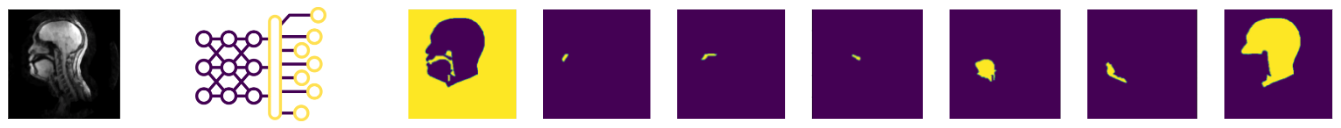

N.B: During all phases of work, except for the debugged training, use Runtime without accelerator. During actual training, set the GPU as a runtime accelerator and disconnect the GPU after each process to avoid Colab GPU restrictions due to runtime limitations.

## Dependencies

In [ ]:
#Dependencies to load the dataset in tf.data format
!pip install med_dataloader==0.1.12 -q

     |████████████████████████████████| 52.7 MB 120 kB/s 


In [ ]:
#Link colab to the directories of a given google drive account
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH)

Mounted at /content/gdrive


In [ ]:
#Possible usefull dependencies
import med_dataloader as mdl
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import keras

from datetime import datetime
from dateutil.tz import gettz
import SimpleITK as sitk
from PIL import Image, ImageFilter

import scipy
from scipy import signal
import cv2

import pickle
import warnings

import albumentations as A
import random
import statistics
from scipy.spatial.distance import directed_hausdorff

warnings.filterwarnings('ignore')

In [ ]:
# useful paths
WD_PATH = os.path.join(ROOT_PATH, 'Shareddrives', 'Neuro - PW3', 'Mattia')
DATASET_PATH = os.path.join(ROOT_PATH, 'Shareddrives', 'Neuro - PW3', 'Dataset_GS')
MODELS_PATH = os.path.join(WD_PATH, 'Models',)

## Dataset exploration

In [ ]:
# list of unchached images' file name
images = os.listdir('/content/gdrive/Shareddrives/Neuro - PW3/Uncached Dataset/GS_images')

In [ ]:
# exctract the subjects
subjects = set([i[:6] for i in images])
subjects = sorted(list(subjects))
subjects

['s00001', 's00002', 's00004', 's00005']

In [ ]:
# count the images for each subject
images_for_subjects = [0, 0, 0, 0]
for image in images:
    i = subjects.index(image[:6])
    images_for_subjects[i] += 1
images_for_subjects

[280, 240, 150, 150]

since medical data coming from the same patient are highly correlated we want data from a single patient not to be shared in the different sets.
So we propose the following split:


*   Train: s00001 + s00002 (63%)
*   Val: s00003 (18%)
*   Test: s00004 (18%)



In [ ]:
class_labels = {
    0: 'Background',
    1: 'Upper lip',
    2: 'Hard palate',
    3: 'Soft palate',
    4: 'Tongue',
    5: 'Lower lip',
    6: 'Head'
}  


## Data Loader

In [ ]:
#Parameters as global variables
NUM_CLASSES = 7
BATCH_SIZE = 8
EPOCHS = 70

#Data augmentation *args (not necessary)
DATA_AUGMENTATION = False
ROTATION = False
FLIP = False
CROP_SIZE = None

#Percentages for dataset splitting
# keep the split [1,0,0] because we will divide manually based on patient
PERC_TRAIN_DATA = 1              #Percentage of the total dataset that will be used for training --> backpropagation and updating of weights and bias are based only on this data
PERC_VALIDATION_DATA = 0         #Percentage of the total dataset that will be used during training to evaluate if the Net is overfitting
PERC_TEST_DATA = 0               #Percentage of the total dataset that will be used after training to evaluate the global Net performances


train_ds, validation_ds, test_ds = mdl.get_dataset(data_dir = DATASET_PATH,
                                                    percentages = [PERC_TRAIN_DATA, PERC_VALIDATION_DATA, PERC_TEST_DATA],
                                                    batch_size = BATCH_SIZE,
                                                    train_augmentation = DATA_AUGMENTATION,
                                                    random_crop_size = CROP_SIZE,
                                                    random_rotate = ROTATION,
                                                    random_flip = FLIP,
                                                    )

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

i = 0
for img, lbl in train_ds.unbatch():
    x_train.append(img)
    y_train.append(lbl)
    i += 1

for img, lbl in validation_ds.unbatch():
    x_val.append(img)
    y_val.append(lbl)
    i += 1

for img, lbl in test_ds.unbatch():
    x_test.append(img)
    y_test.append(lbl)
    i += 1

print('Tot Imgs: {}'.format(i))

#From list to tensor
x_train = np.asarray(x_train) 
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

#Some info
print('x_train shape: {}  y_train shape: {}'.format(x_train.shape, y_train.shape))
print('x_val shape: {}  y_val shape: {}'.format(x_val.shape, y_val.shape))
print('x_test shape: {}  y_test shape: {}'.format(x_test.shape, y_test.shape))

Tot Imgs: 820
x_train shape: (820, 256, 256, 1)  y_train shape: (820, 256, 256, 7)
x_val shape: (0,)  y_val shape: (0,)
x_test shape: (0,)  y_test shape: (0,)


In [ ]:
# split manually the test set
x_test = x_train[-150:]
y_test = y_train[-150:]
print(x_test.shape)
print(y_test.shape)

(150, 256, 256, 1)
(150, 256, 256, 7)


In [ ]:
# split manually the validation set
x_val = x_train[520:-150]
y_val = y_train[520:-150]
print(x_val.shape)
print(y_val.shape)

(150, 256, 256, 1)
(150, 256, 256, 7)


In [ ]:
# split manually the training set
x_train = x_train[:520]
y_train = y_train[:520]
print(x_train.shape)
print(y_train.shape)

(520, 256, 256, 1)
(520, 256, 256, 7)


## Preprocessing

In [ ]:
def denoise(img, weight=0.015, eps=1e-3, num_iter_max=100):
  """
  Rudin, Osher and Fatemi algorithm.
  Perform total-variation denoising on a grayscale image.
    
  Parameters
  ----------
  img : 2-D input data to be de-noised.
  weight : float, optional. The greater `weight`, the more de-noising
  eps : float, optional. The algorithm stops when:
            (E_(n-1) - E_n) < eps * E_0
  num_iter_max : int, optional

  Returns
  -------
  out : array, De-noised array of floats.
    
  Source
  -----
  https://github.com/minhducubc97/Image-Processing/blob/master/Denoise/DNmethod2%20%5BBEST%5D.py
  """
  u = np.zeros_like(img)
  px = np.zeros_like(img)
  py = np.zeros_like(img)
    
  nm = np.prod(img.shape[:2])
  tau = 0.125
    
  i = 0
  while i < num_iter_max:
      u_old = u
      ux = np.roll(u, -1, axis=1) - u
      uy = np.roll(u, -1, axis=0) - u
      px_new = px + (tau / weight) * ux
      py_new = py + (tau / weight) * uy
      norm_new = np.maximum(1, np.sqrt(px_new **2 + py_new ** 2))
      px = px_new / norm_new
      py = py_new / norm_new
      rx = np.roll(px, 1, axis=1)
      ry = np.roll(py, 1, axis=0)
      div_p = (px - rx) + (py - ry)
        
      # update image
      u = img + weight * div_p
      error = np.linalg.norm(u - u_old) / np.sqrt(nm)
      if i == 0:
            err_init = error
            err_prev = error
      else:
            # break if error small enough
          if np.abs(err_prev - error) < eps * err_init:
              break
          else:
              e_prev = error
                
        # don't forget to update iterator
      i += 1

  return u

In [ ]:
def remove_gaussian_noise(dataset):
  """
  given a dataset of images it return the denoised version
  """
  dataset_denoised = denoise(dataset[0,:,:,0])
  dataset_denoised = (dataset_denoised-np.min(dataset_denoised))/(np.max(dataset_denoised)-np.min(dataset_denoised))
  dataset_denoised = np.expand_dims(dataset_denoised,axis=0)

  for img in dataset[1:]:
    new_img = denoise(img[:,:,0])
    new_img = (new_img-np.min(new_img))/(np.max(new_img)-np.min(new_img))
    new_img = np.expand_dims(new_img,axis=0)
    dataset_denoised = np.concatenate((dataset_denoised, new_img), axis=0)
  
  dataset_denoised = np.expand_dims(dataset_denoised,axis=3)

  return dataset_denoised

In [ ]:
def enhance_high_frequencies(dataset):
  """
  given a dataset of images it returns a version where the high frequency 
  components have been enhanced
  """

  h = np.array([[-1, -1, -1],
                [-1, 20, -1],
                [-1, -1, -1]])
  dataset_enhanced = signal.convolve2d(dataset[0,:,:,0], h, mode='same', boundary='symm')
  dataset_enhanced = (dataset_enhanced-np.min(dataset_enhanced))/(np.max(dataset_enhanced)-np.min(dataset_enhanced))
  dataset_enhanced = np.expand_dims(dataset_enhanced,axis=0)

  for img in dataset[1:]:
    next_img = signal.convolve2d(img[:,:,0], h, mode='same', boundary='symm')
    next_img = (next_img-np.min(next_img))/(np.max(next_img)-np.min(next_img))
    next_img = np.expand_dims(next_img,axis=0)
    dataset_enhanced = np.concatenate((dataset_enhanced, next_img), axis=0)
  
  dataset_enhanced = np.expand_dims(dataset_enhanced,axis=3)

  return dataset_enhanced

In [ ]:
def preprocessing(dataset):
  dataset = remove_gaussian_noise(dataset)
  dataset = enhance_high_frequencies(dataset)
  return dataset

In [ ]:
x_train_denoised = preprocessing(x_train)
x_val_denoised = preprocessing(x_val)

(-0.5, 39.5, 39.5, -0.5)

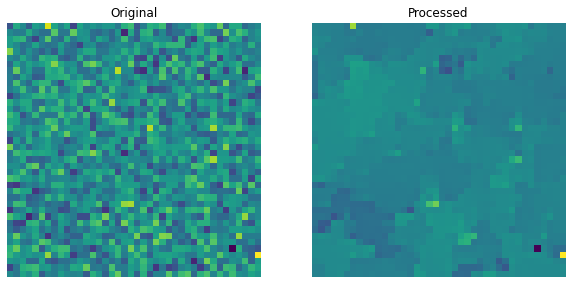

In [ ]:
# top right corner of an image before and after the preprocessing
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train[0,:40,:40,0])
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(x_train_denoised[0,:40,:40,0])
plt.title('Processed')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

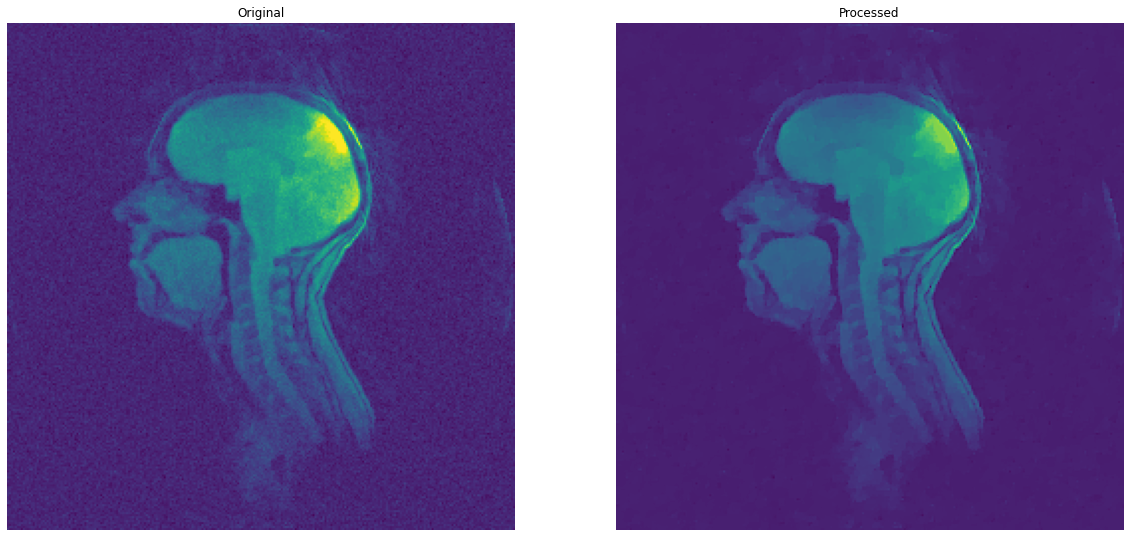

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(x_train[0,:,:,0])
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x_train_denoised[0,:,:,0])
plt.title('Processed')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

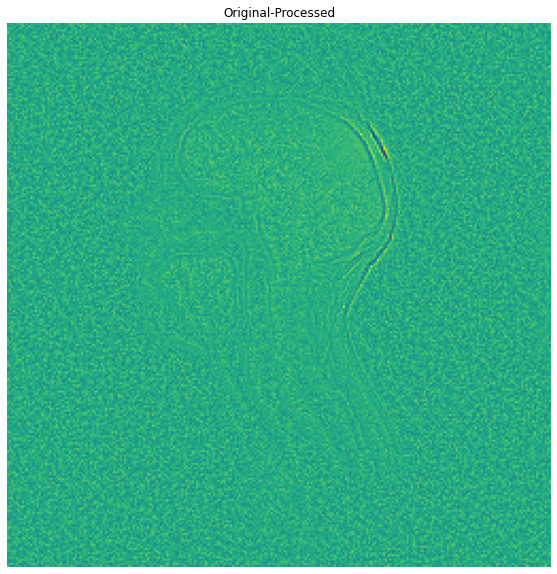

In [ ]:
# difference from the original image and its preprocessed version
diff = x_train[0,:,:,0]-x_train_denoised[0,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(diff)
plt.title('Original-Processed')
plt.axis('off')

Text(0.5, 1.0, 'Distibution of difference')

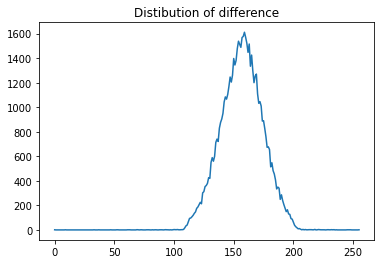

In [ ]:
# histogram of the difference
plt.plot(np.histogram(diff, 256)[0])
plt.title('Distibution of difference')

In [ ]:
x_train_denoised.shape

(520, 256, 256, 1)

In [ ]:
x_val_denoised.shape

(150, 256, 256, 1)

In [ ]:
x_train = x_train_denoised
x_val = x_val_denoised

del x_train_denoised
del x_val_denoised

## Data Augmentation

In [ ]:
# set seed for same augmentation 
seed = 42

random.seed(seed)
np.random.seed(seed)

In [ ]:
# define the types of augmentation to apply
augmentation = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=20, p=0.5, border_mode=1),
])

In [ ]:
def data_augmentation(x_train, y_train, augmentation):
  """
  Given a dataset with relative masks, it apply data augmentation and return the 
  combination of the original dataset and the augmented one shuffled.
  The dimensions of the dataset double
  """
  x_train_aug = x_train
  y_train_aug = y_train

  for i in range(len(x_train)):
    img = x_train[i,:,:,0]
    mask = y_train[i,:,:,:]

    augmented = augmentation(image=img, mask=mask)

    img = augmented['image']
    mask = augmented['mask']

    x_train_aug[i,:,:,0] = img
    y_train_aug[i,:,:,:] = mask

  x_train = np.concatenate((x_train, x_train_aug), axis = 0)
  y_train = np.concatenate((y_train, y_train_aug), axis = 0)

  p = np.random.permutation(len(x_train))
  return x_train[p], y_train[p]

In [ ]:
x_train, y_train = data_augmentation(x_train, y_train, augmentation)

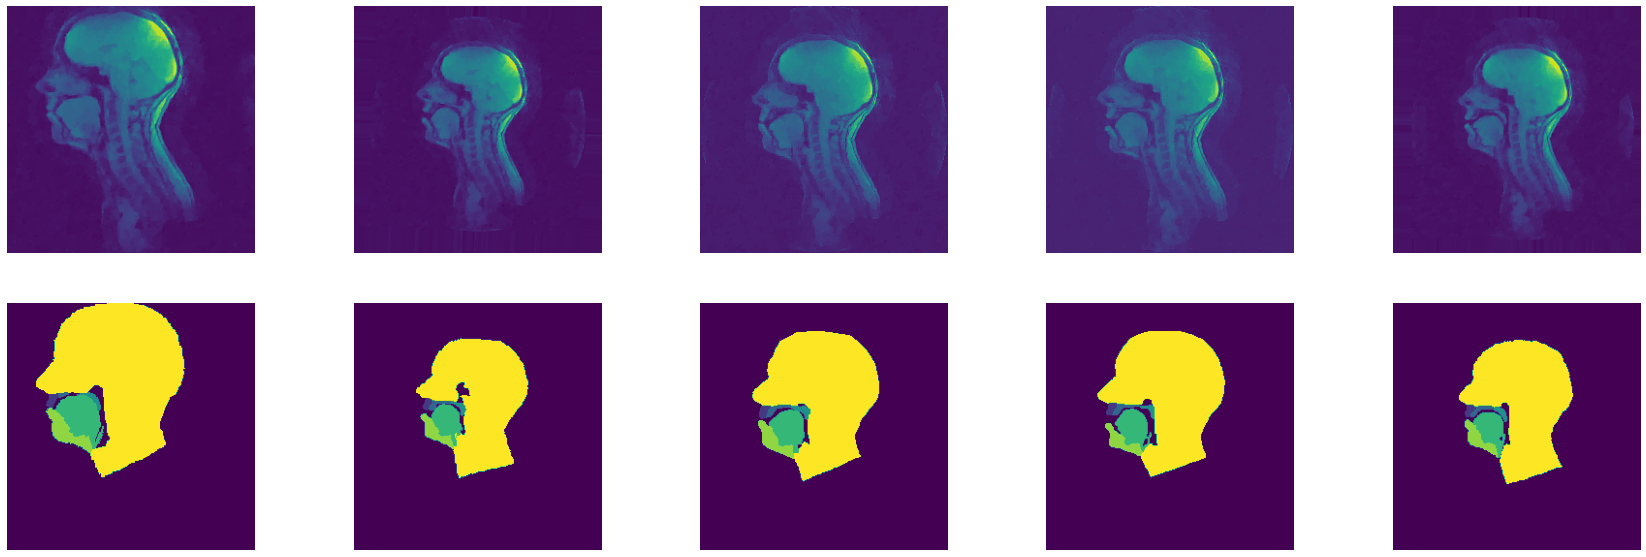

In [ ]:
# plot random images with masks to see effects of data augmentation
plt.figure(figsize=(30,10))

imgs = np.random.randint(0, len(x_train), (1,5))

for i in range(10):
  plt.subplot(2,5,i+1)
  if i<5:
    j = imgs[0][i]
    plt.imshow(x_train[j,:,:,0])
    plt.axis('off')
  else:
    j = imgs[0][i%5]
    plt.imshow(tf.math.argmax(y_train[j], axis=-1))
    plt.axis('off')

## Dataset Visualization

  Img n°: 0 ↓ 


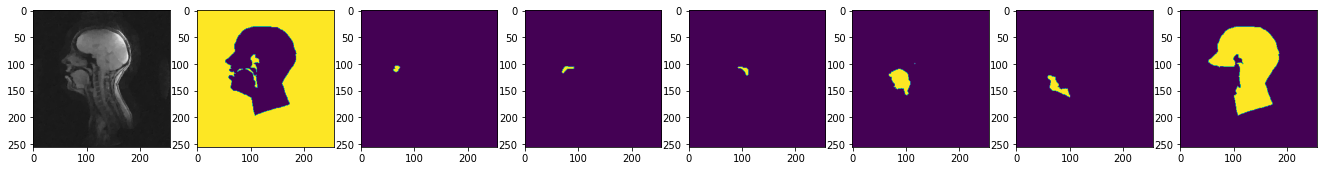

  Img n°: 1 ↓ 


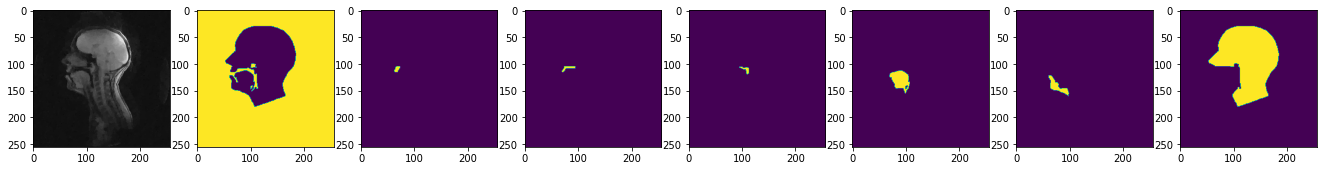

  Img n°: 2 ↓ 


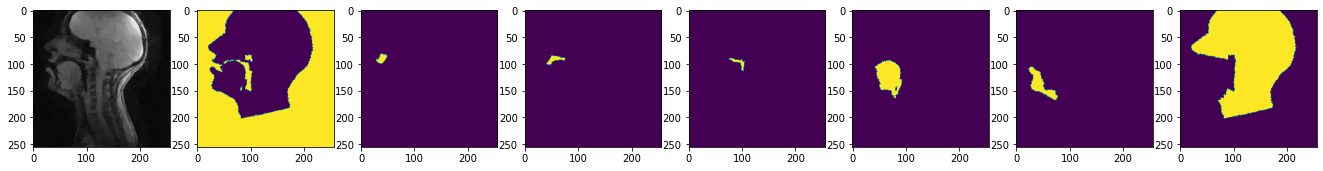

  Img n°: 3 ↓ 


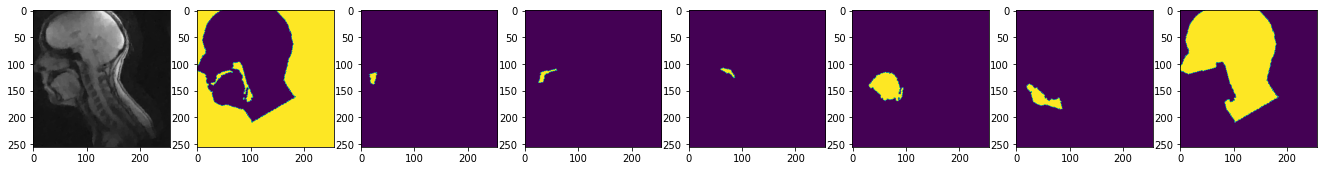

  Img n°: 4 ↓ 


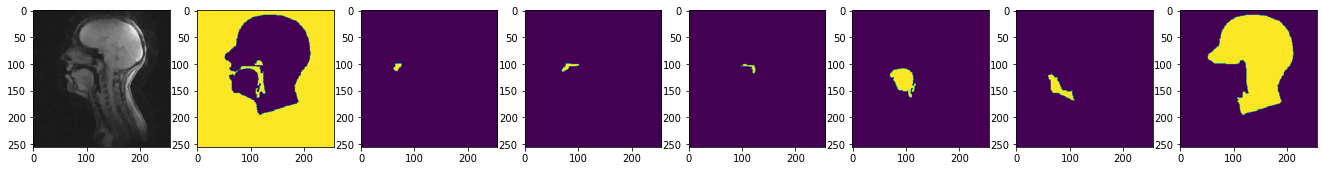

In [ ]:
n = 0
for volume, label in zip(x_train, y_train):

    print("\033[92m \033[1m Img n°: {} ↓ \033[0m".format(n))
    fig = plt.figure(figsize = [23, 7]) 
    plt.subplot(1, NUM_CLASSES + 1, 1) 
    plt.imshow(volume[:,:,0], cmap="gray")

    for i in range(NUM_CLASSES):
        plt.subplot(1, NUM_CLASSES + 1, i+2)
        plt.imshow(label[:,:,i])
    
    n += 1

    if n == 5:
      break
    plt.show(fig)

## Loss Function

Weighted Cross Entropy:  $\, L_{CE} = -\sum_{c=1}^{C} \frac{1}{N} \sum_{i=1}^{N} w^c\,g_i^c\,log\,p_i^c \quad$ [[1]](https://www.sciencedirect.com/science/article/pii/S1361841521000815)

where:
* $C$ = n°classes
* $N$ = n°pixels of image (256x256)
* $g_i^c$ = value of the $i^{th}$ pixel of the $c^{th}$ class of the ground truth label
* $p_i^c$ = value of the $i^{th}$ pixel of the $c^{th}$ class of the predicted label
* $w^c$ = weight of the $c^{th}$ class

In [ ]:
# compute the weights for each class

element_per_class = {}
weights = {}
for i in range(NUM_CLASSES):
    element_per_class[i] = 0
    weights[i] = 0.0

for j in range(len(y_train)):
  img = y_train[j,:,:,:]
  for i in range(NUM_CLASSES):
    element_per_class[i] += np.count_nonzero(img[:,:,i] == 1)

for i in weights.keys():
    weights[i] = sum(element_per_class.values()) / (NUM_CLASSES * element_per_class[i])

weights

{0: 0.18179355089294366,
 1: 92.28647795250643,
 2: 63.655708308427975,
 3: 94.64575938855654,
 4: 8.540343360761362,
 5: 17.06105312905359,
 6: 0.7773393598556978}

In [ ]:
def cross_entropy(num_classes, weights):
    def loss(y_true, y_pred): #called each iteration (step)

        if len(y_pred.shape) == 4: #2D image
            axis = (1,2)
        elif len(y_pred.shape) == 5: #3D volume
            axis == (1,2,3)

        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)
        
        loss_image = 0.0
        loss_ce = 0.0

        for c in range(num_classes):

            loss_image = tf.math.add(-1*(tf.math.reduce_mean(tf.math.multiply(weights[c]*y_true[...,c], tf.math.log(y_pred[...,c] + 1e-9)), axis = axis)), loss_image)
                                
        loss_ce = tf.math.reduce_mean(loss_image)

        return loss_ce

    return loss

## Metric



* Mean Dice: $\, DICE = \frac{1}{C}  \sum_{c = 1}^{C} \frac{2 \lvert S_g^c \cap S_p^c \rvert}{\lvert S_g^c \rvert + \lvert S_p^c \rvert} = \frac{2\,\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c\,p_i^c}{\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c \,+\, \sum_{c=1}^{C}\sum_{i=1}^{N}p_i^c  } \quad$ [[3]](https://bmcmedimaging.biomedcentral.com/track/pdf/10.1186/s12880-015-0068-x.pdf)

* Hausdorff distance: $d_H(X,Y) = max \big\{\sup d(x,Y), \, \sup d(X,y) \big\}$ <br> with $x \in X$ and $y \in Y \quad$ [[4]](https://en.wikipedia.org/wiki/Hausdorff_distance)

In [ ]:
class Mean_DICE(tf.keras.metrics.Metric):
    def __init__(self,
                 num_classes,
                 name='Mean_DICE',
                 smooth_factor = 1e-9,
                 **kwargs):

        super().__init__(name = name, **kwargs)
        self.num_classes = num_classes
        self.axis = None
        self.smooth_factor = smooth_factor

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        num_classes = self.num_classes
        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)
        
        dice_classes = 0.0
        dice_image = 0.
        
        if len(y_pred.shape) == 4:
            self.axis = (1,2)
        elif len(y_pred.shape) == 5:
            self.axis = (1,2,3)

        for c in range(num_classes):

            abs_label = tf.math.reduce_sum(y_true[...,c], axis = self.axis )
            abs_pred = tf.math.reduce_sum(y_pred[...,c], axis = self.axis )
            MD_batch_denom = tf.math.add(tf.math.add(abs_label, abs_pred), self.smooth_factor)
            MD_batch_num = tf.math.add(2*tf.math.reduce_sum(tf.math.multiply(y_true[...,c], y_pred[...,c]), axis = self.axis), self.smooth_factor)
            dice_image = tf.math.divide(MD_batch_num, MD_batch_denom)
            dice_classes = tf.math.add(dice_image, dice_classes)

        self.mean_dice = tf.math.divide(dice_classes, num_classes)
        self.mean_dice = tf.math.reduce_mean(self.mean_dice)

    def result(self):
        return self.mean_dice
  
    def get_config(self):
        config = super().get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @ classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
from scipy.spatial.distance import directed_hausdorff

class Hausdorff(tf.keras.metrics.Metric):
    def __init__(self,
                 num_classes,
                 name='Hausdorff',
                 **kwargs):

        super().__init__(name = name, **kwargs)
        self.num_classes = num_classes
        self.axis = None

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        num_classes = self.num_classes
        y_true = y_true.numpy()
        y_pred = y_pred.numpy()
        dhs=[]

        for i, val in enumerate(y_true):
          preda = y_pred[i]
          val = tf.math.argmax(val, axis=-1)
          preda = tf.math.argmax(preda, axis=-1)
          preda = np.array(preda)
          preda = np.reshape(preda, (256, 256))
          dh = directed_hausdorff(val, preda)[0]
          dhs.append(dh)

        self.hausdorff = sum(dhs)/len(dhs)

    def result(self):
        return self.hausdorff
  
    def get_config(self):
        config = super().get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @ classmethod
    def from_config(cls, config):
        return cls(**config)

## Callback

In [ ]:
# allow us to plot (and save) the prediction on an image of the validation set at each
# epoch during the training

class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, image, label, folder_path):
        super().__init__()
        self.image = image
        self.label = label
        self.folder_path = folder_path
    
    def on_epoch_end(self, epoch, logs=None):
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (256, 256))

        y_label = tf.math.argmax(self.label, axis=-1)
        y_label = np.array(y_label)
        y_label = np.reshape(y_label, (256, 256))


        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(y_label)
        plt.axis('off')
        ax1.set_title('Label')

        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(y_pred)
        ax2.set_title('Prediction')
        plt.axis('off')
        plt.tight_layout()

        extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        path = os.path.join(self.folder_path, str(epoch))
        fig.savefig(path, bbox_inches=extent.expanded(1, 0.75))

        plt.show()
        

## Architectures

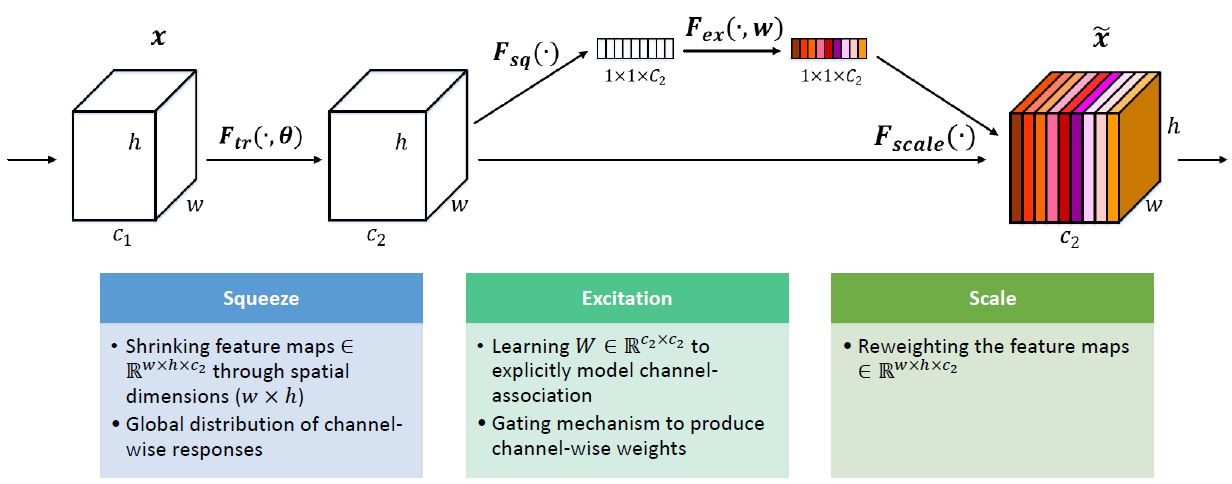

The intuition behind is that **channels might not have the same representative importance**. As some channels might be more important than others, it makes sense to apply a weight to the channels based on their importance before propagating to the next layer.

The module is called a Squeeze-and-Excite block (abbreviated as SE-block) which consists of three components (shown in the figure above):


1.   **Squeeze Module**: reduces the spatial dimensions of the feature maps to a singular value. In CNN there is pooling. The authors also did an ablation study to investigate the performance of global average pooling versus global max pooling. The former won;
2.   **Excitation Module**: bottleneck structure to map the scaling weight. It adds non linearity and reduces complexity with an hyperparameter *r*;
3.   **Scale Module**: it passes the output of the previous module through a sigmoid activation layer which scales the values to a range of 0-1. Subsequently the output is applied directly to the input by a simple broadcasted element-wise multiplication.

In [ ]:
def se_block(in_block, ch, ratio=16):
    x = layers.GlobalAveragePooling2D()(in_block)
    x = layers.Dense(ch//ratio, activation='relu')(x)
    x = layers.Dense(ch, activation='sigmoid')(x)
    x = layers.multiply([in_block, x])
    return x

In [ ]:
def residual(input, block_type, num_filters=16, kernel_size=(1, 1), padding='same'):
  """
  Compute the output of the residual branch in encoder or decoder block
  """

  if block_type == 'encoder':
    output = layers.Conv2D(num_filters, kernel_size, padding = padding, kernel_initializer="he_uniform")(input)
  else:
    output = layers.Conv2DTranspose(num_filters, kernel_size, padding = padding, kernel_initializer="he_uniform")(input)

  output = layers.BatchNormalization()(output)
  output = se_block(output, ch=num_filters)

  return output

In [ ]:
def initial_blocks(input, num_filters=16, kernel_size=(3, 3), padding='same', activation='relu'):
  """
  Build the inital blocks of the unet
  """

  output = layers.Conv2D(num_filters, kernel_size, padding=padding, kernel_initializer="he_uniform")(input)
  output = layers.BatchNormalization()(output)
  output = layers.Activation(activation)(output)

  res = residual(input, block_type='encoder', num_filters=num_filters)

  output = layers.Add()([output, res])

  return output

In [ ]:
def bac(input, block_type, num_filters=16, kernel_size=(3, 3), activation='relu', padding='same'):
  """
  BatchNormalization - Activation - Convolution
  """

  output = layers.BatchNormalization()(input)
  output = layers.Activation(activation)(output)

  if block_type == 'encoder':
    output = layers.Conv2D(num_filters, kernel_size, padding=padding, kernel_initializer="he_uniform")(output)
  else:
    output = layers.Conv2DTranspose(num_filters, kernel_size, padding=padding, kernel_initializer="he_uniform")(output)

  return output


In [ ]:
def encoder_block(input, concatenation, num_filters=16, kernel_size=(3, 3), activation='relu', padding='same', dropout_rate=0, pool_size=(2, 2)):
  """
  Encoding layer
  """

  output = bac(input, 'encoder', num_filters, kernel_size, activation, padding)
  output = bac(output, 'encoder', num_filters, kernel_size, activation, padding)

  output = se_block(output, ch=num_filters)

  res = residual(input, block_type='encoder', num_filters=num_filters)

  output = layers.Add()([output, res])

  concatenation.append(output)

  output = layers.MaxPooling2D(pool_size=pool_size)(output)
  output = layers.Dropout(rate=dropout_rate)(output)

  return output


In [ ]:
def decoder_block(input, concatenation, num_filters=16, kernel_size=(3, 3), activation='relu', padding='same', dropout_rate=0):
  """
  Decoding layer
  """

  output = layers.Conv2DTranspose(num_filters, kernel_size=(1,1), strides=(2, 2), padding=padding, kernel_initializer="he_uniform")(input)
  output = layers.BatchNormalization()(output)

  output = layers.concatenate([output, concatenation.pop()])

  output = layers.Dropout(rate=dropout_rate)(output)

  res = residual(output, block_type='decoder', num_filters=num_filters)

  output = bac(output, 'decoder', num_filters, kernel_size, activation, padding)
  output = bac(output, 'decoder', num_filters, kernel_size, activation, padding)

  output = se_block(output, ch=num_filters)

  output = layers.Add()([output, res])

  return output


In [ ]:
def build_model():

  input = keras.Input(shape=(256,256,1))

  unet = initial_blocks(input, num_filters=16)

  concatenation = []

  unet = encoder_block(unet, concatenation=concatenation, num_filters=32)
  unet = encoder_block(unet, concatenation=concatenation, num_filters=64)
  unet = encoder_block(unet, concatenation=concatenation, num_filters=128)
  unet = encoder_block(unet, concatenation=concatenation, num_filters=256)

  unet = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', dilation_rate=1, activation='relu', kernel_initializer="he_uniform")(unet)
  unet = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', dilation_rate=2, activation='relu', kernel_initializer="he_uniform")(unet)
  unet = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', dilation_rate=4, activation='relu', kernel_initializer="he_uniform")(unet)
  unet = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', dilation_rate=8, activation='relu', kernel_initializer="he_uniform")(unet)


  unet = decoder_block(unet, concatenation=concatenation, num_filters=256)
  unet = decoder_block(unet, concatenation=concatenation, num_filters=128)
  unet = decoder_block(unet, concatenation=concatenation, num_filters=64)
  unet = decoder_block(unet, concatenation=concatenation, num_filters=32)

  output = layers.Conv2D(NUM_CLASSES, kernel_size=(1, 1), padding='same', activation='softmax', kernel_initializer="glorot_uniform")(unet)

  model = Model(inputs=input, outputs=output)

  return model


## Model Building & Callbacks

In [ ]:
#Build Model --> instantiate the weights of the defined architecture according to the choosen mode 

model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 16  32          ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_31 (BatchN  (None, 256, 256, 16  64         ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

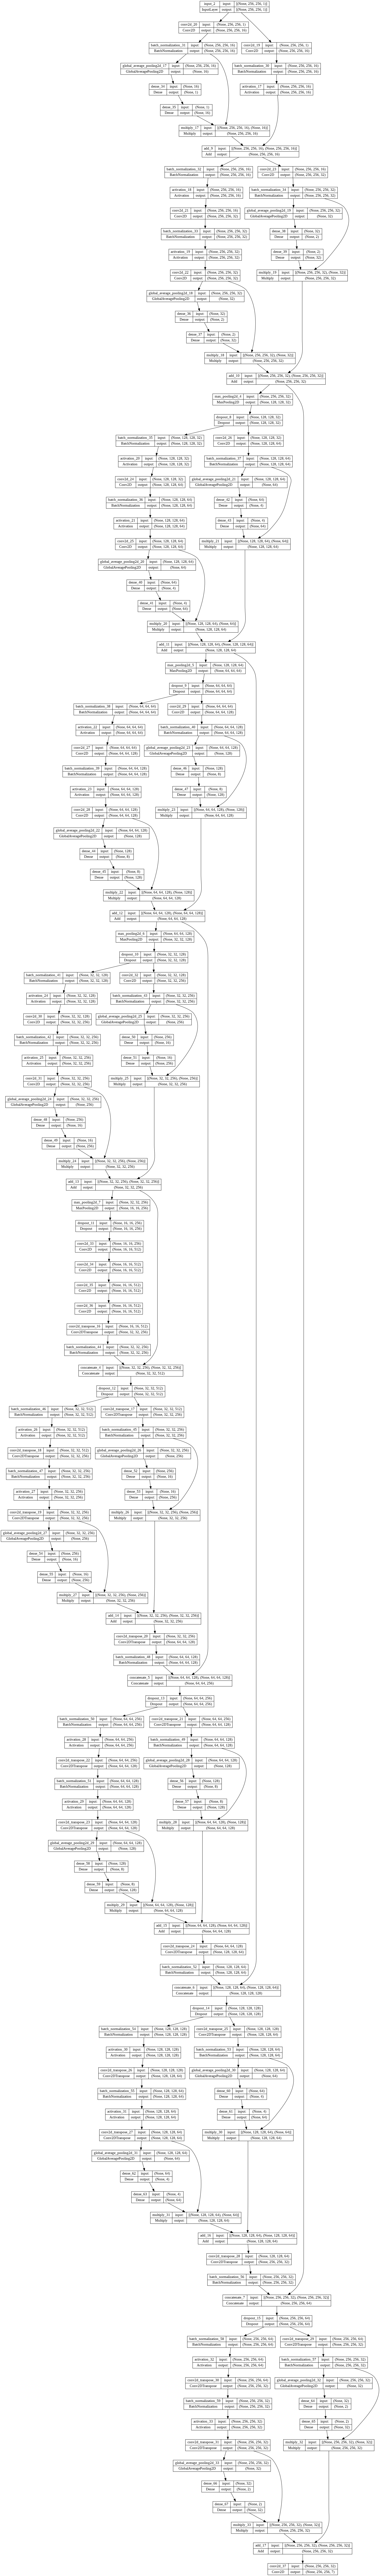

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="unet_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)


In [ ]:
#mode.compile --> define loss, optimizer and metrics to be used during training

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    amsgrad=False,
    name="Adam",
)

model.compile(loss=cross_entropy(NUM_CLASSES, weights),
              optimizer=opt,
              metrics = [Mean_DICE(NUM_CLASSES),
                         tf.keras.metrics.Precision(),
                         tf.keras.metrics.Recall(),
                         Hausdorff(NUM_CLASSES)],
              run_eagerly=True # necessary to compute Hausdorff distance
)

In [ ]:
#Create a directory tree to neatly save the models 
training_path = os.path.join(WD_PATH, 'Training_' + datetime.now(gettz("Europe/Rome")).strftime("%Y-%m-%d-T%H:%M"))
checkpoint_path = os.path.join(training_path, 'Checkpoints')
best_model_path = os.path.join(training_path, 'Best Model')
predictions_path = os.path.join(training_path, 'Predictions Images')

if not os.path.exists(training_path):
    os.mkdir(training_path)
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)
if not os.path.exists(best_model_path):
    os.mkdir(best_model_path)
if not os.path.exists(predictions_path):
    os.mkdir(predictions_path)

In [ ]:
#Callback to keep track of the model with the best validation Mean_DICE

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_Mean_DICE', mode='max', patience=10, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_Mean_DICE', factor=0.5, patience=5, mode='max', verbose=0),
             VizCallback(np.expand_dims(x_val[0],axis=0), np.expand_dims(y_val[0],axis=0), predictions_path),
             #tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_Mean_DICE', verbose=0, mode='max',save_best_only=True )]
]

## Model Training

Epoch 1/1000
130/130 [==============================] - ETA: 0s - loss: 0.3257 - Mean_DICE: 0.7072 - precision_1: 0.9536 - recall_1: 0.8686 - Hausdorff: 23.1834

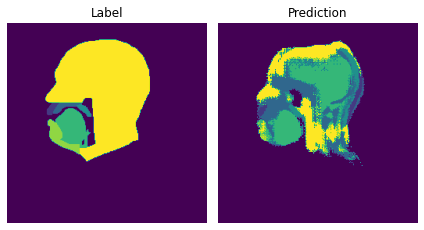

130/130 [==============================] - 78s 597ms/step - loss: 0.3257 - Mean_DICE: 0.7072 - precision_1: 0.9536 - recall_1: 0.8686 - Hausdorff: 23.1834 - val_loss: 1.2972 - val_Mean_DICE: 0.2777 - val_precision_1: 0.8783 - val_recall_1: 0.7837 - val_Hausdorff: 33.1007 - lr: 0.0010
Epoch 2/1000
130/130 [==============================] - ETA: 0s - loss: 0.0985 - Mean_DICE: 0.7123 - precision_1: 0.9734 - recall_1: 0.9711 - Hausdorff: 23.1508

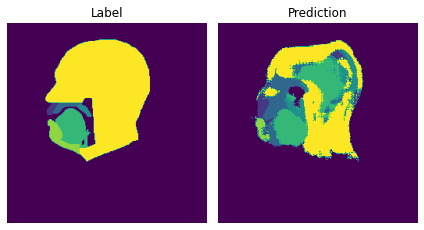

130/130 [==============================] - 80s 616ms/step - loss: 0.0985 - Mean_DICE: 0.7123 - precision_1: 0.9734 - recall_1: 0.9711 - Hausdorff: 23.1508 - val_loss: 0.7427 - val_Mean_DICE: 0.3782 - val_precision_1: 0.9060 - val_recall_1: 0.8503 - val_Hausdorff: 34.0224 - lr: 0.0010
Epoch 3/1000
130/130 [==============================] - ETA: 0s - loss: 0.0873 - Mean_DICE: 0.7417 - precision_1: 0.9763 - recall_1: 0.9748 - Hausdorff: 22.6580

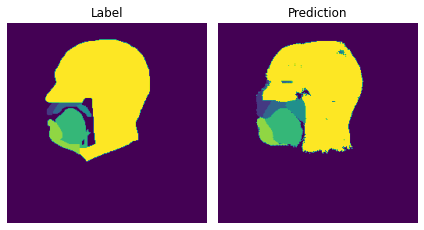

130/130 [==============================] - 75s 579ms/step - loss: 0.0873 - Mean_DICE: 0.7417 - precision_1: 0.9763 - recall_1: 0.9748 - Hausdorff: 22.6580 - val_loss: 0.2185 - val_Mean_DICE: 0.6473 - val_precision_1: 0.9568 - val_recall_1: 0.9470 - val_Hausdorff: 31.0107 - lr: 0.0010
Epoch 4/1000
130/130 [==============================] - ETA: 0s - loss: 0.0811 - Mean_DICE: 0.7385 - precision_1: 0.9772 - recall_1: 0.9760 - Hausdorff: 21.5162

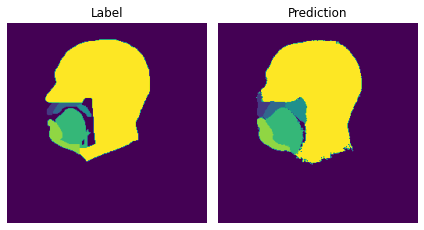

130/130 [==============================] - 75s 574ms/step - loss: 0.0811 - Mean_DICE: 0.7385 - precision_1: 0.9772 - recall_1: 0.9760 - Hausdorff: 21.5162 - val_loss: 0.1364 - val_Mean_DICE: 0.7306 - val_precision_1: 0.9728 - val_recall_1: 0.9687 - val_Hausdorff: 21.2973 - lr: 0.0010
Epoch 5/1000
130/130 [==============================] - ETA: 0s - loss: 0.0757 - Mean_DICE: 0.7926 - precision_1: 0.9781 - recall_1: 0.9769 - Hausdorff: 23.4948

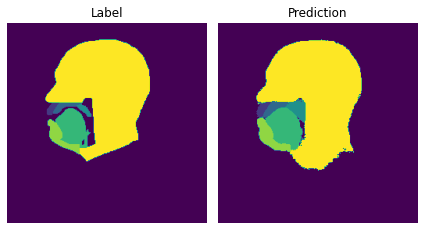

130/130 [==============================] - 73s 559ms/step - loss: 0.0757 - Mean_DICE: 0.7926 - precision_1: 0.9781 - recall_1: 0.9769 - Hausdorff: 23.4948 - val_loss: 0.0987 - val_Mean_DICE: 0.7872 - val_precision_1: 0.9725 - val_recall_1: 0.9705 - val_Hausdorff: 21.8337 - lr: 0.0010
Epoch 6/1000
130/130 [==============================] - ETA: 0s - loss: 0.0683 - Mean_DICE: 0.7810 - precision_1: 0.9794 - recall_1: 0.9784 - Hausdorff: 22.9138

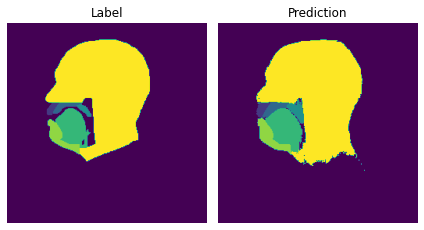

130/130 [==============================] - 74s 569ms/step - loss: 0.0683 - Mean_DICE: 0.7810 - precision_1: 0.9794 - recall_1: 0.9784 - Hausdorff: 22.9138 - val_loss: 0.1005 - val_Mean_DICE: 0.7941 - val_precision_1: 0.9715 - val_recall_1: 0.9691 - val_Hausdorff: 23.9226 - lr: 0.0010
Epoch 7/1000
130/130 [==============================] - ETA: 0s - loss: 0.0624 - Mean_DICE: 0.8070 - precision_1: 0.9802 - recall_1: 0.9793 - Hausdorff: 21.9109

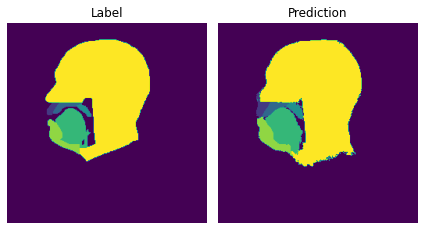

130/130 [==============================] - 73s 563ms/step - loss: 0.0624 - Mean_DICE: 0.8070 - precision_1: 0.9802 - recall_1: 0.9793 - Hausdorff: 21.9109 - val_loss: 0.0978 - val_Mean_DICE: 0.7929 - val_precision_1: 0.9703 - val_recall_1: 0.9683 - val_Hausdorff: 26.6720 - lr: 0.0010
Epoch 8/1000
130/130 [==============================] - ETA: 0s - loss: 0.0714 - Mean_DICE: 0.7777 - precision_1: 0.9783 - recall_1: 0.9771 - Hausdorff: 21.2286

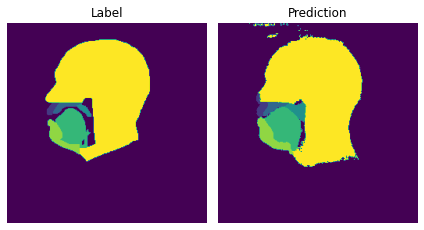

130/130 [==============================] - 74s 570ms/step - loss: 0.0714 - Mean_DICE: 0.7777 - precision_1: 0.9783 - recall_1: 0.9771 - Hausdorff: 21.2286 - val_loss: 0.1582 - val_Mean_DICE: 0.8068 - val_precision_1: 0.9608 - val_recall_1: 0.9596 - val_Hausdorff: 23.7335 - lr: 0.0010
Epoch 9/1000
130/130 [==============================] - ETA: 0s - loss: 0.0597 - Mean_DICE: 0.7830 - precision_1: 0.9797 - recall_1: 0.9788 - Hausdorff: 23.6975

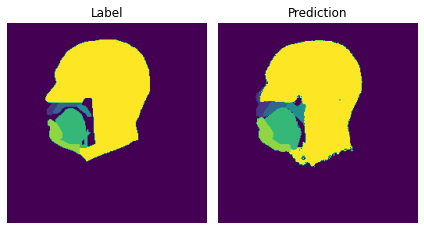

130/130 [==============================] - 74s 573ms/step - loss: 0.0597 - Mean_DICE: 0.7830 - precision_1: 0.9797 - recall_1: 0.9788 - Hausdorff: 23.6975 - val_loss: 0.1051 - val_Mean_DICE: 0.7762 - val_precision_1: 0.9740 - val_recall_1: 0.9718 - val_Hausdorff: 22.7475 - lr: 0.0010
Epoch 10/1000
130/130 [==============================] - ETA: 0s - loss: 0.0492 - Mean_DICE: 0.8201 - precision_1: 0.9822 - recall_1: 0.9816 - Hausdorff: 20.3628

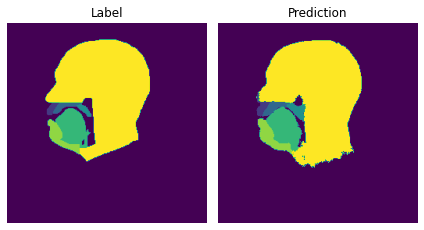

130/130 [==============================] - 74s 572ms/step - loss: 0.0492 - Mean_DICE: 0.8201 - precision_1: 0.9822 - recall_1: 0.9816 - Hausdorff: 20.3628 - val_loss: 0.1023 - val_Mean_DICE: 0.8047 - val_precision_1: 0.9751 - val_recall_1: 0.9735 - val_Hausdorff: 22.9001 - lr: 0.0010
Epoch 11/1000
130/130 [==============================] - ETA: 0s - loss: 0.0466 - Mean_DICE: 0.8082 - precision_1: 0.9826 - recall_1: 0.9820 - Hausdorff: 19.6993

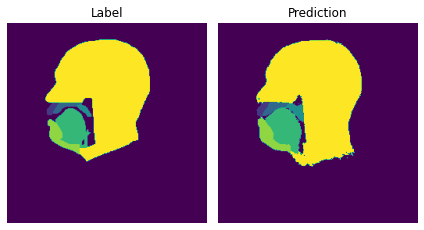

130/130 [==============================] - 74s 571ms/step - loss: 0.0466 - Mean_DICE: 0.8082 - precision_1: 0.9826 - recall_1: 0.9820 - Hausdorff: 19.6993 - val_loss: 0.1145 - val_Mean_DICE: 0.8158 - val_precision_1: 0.9736 - val_recall_1: 0.9717 - val_Hausdorff: 24.7382 - lr: 0.0010
Epoch 12/1000
130/130 [==============================] - ETA: 0s - loss: 0.0447 - Mean_DICE: 0.8041 - precision_1: 0.9838 - recall_1: 0.9833 - Hausdorff: 22.3805

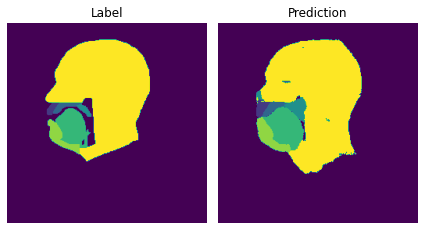

130/130 [==============================] - 75s 575ms/step - loss: 0.0447 - Mean_DICE: 0.8041 - precision_1: 0.9838 - recall_1: 0.9833 - Hausdorff: 22.3805 - val_loss: 0.1312 - val_Mean_DICE: 0.7672 - val_precision_1: 0.9640 - val_recall_1: 0.9623 - val_Hausdorff: 24.6933 - lr: 0.0010
Epoch 13/1000
130/130 [==============================] - ETA: 0s - loss: 0.0415 - Mean_DICE: 0.8334 - precision_1: 0.9841 - recall_1: 0.9837 - Hausdorff: 21.2225

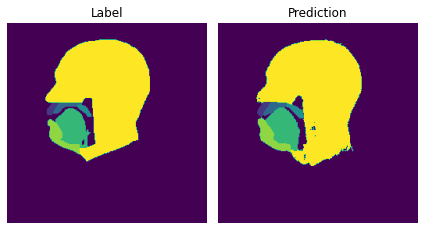

130/130 [==============================] - 73s 562ms/step - loss: 0.0415 - Mean_DICE: 0.8334 - precision_1: 0.9841 - recall_1: 0.9837 - Hausdorff: 21.2225 - val_loss: 0.1657 - val_Mean_DICE: 0.8423 - val_precision_1: 0.9781 - val_recall_1: 0.9767 - val_Hausdorff: 24.8710 - lr: 0.0010
Epoch 14/1000
130/130 [==============================] - ETA: 0s - loss: 0.0372 - Mean_DICE: 0.8482 - precision_1: 0.9850 - recall_1: 0.9846 - Hausdorff: 20.4841

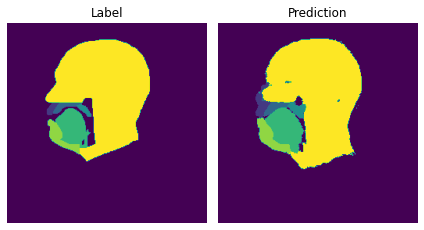

130/130 [==============================] - 73s 562ms/step - loss: 0.0372 - Mean_DICE: 0.8482 - precision_1: 0.9850 - recall_1: 0.9846 - Hausdorff: 20.4841 - val_loss: 0.1257 - val_Mean_DICE: 0.7709 - val_precision_1: 0.9677 - val_recall_1: 0.9664 - val_Hausdorff: 24.8555 - lr: 0.0010
Epoch 15/1000
130/130 [==============================] - ETA: 0s - loss: 0.0351 - Mean_DICE: 0.8435 - precision_1: 0.9856 - recall_1: 0.9852 - Hausdorff: 20.1967

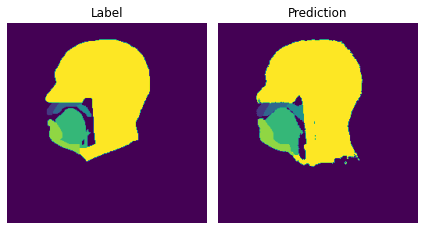

130/130 [==============================] - 73s 560ms/step - loss: 0.0351 - Mean_DICE: 0.8435 - precision_1: 0.9856 - recall_1: 0.9852 - Hausdorff: 20.1967 - val_loss: 0.1250 - val_Mean_DICE: 0.8190 - val_precision_1: 0.9720 - val_recall_1: 0.9709 - val_Hausdorff: 25.4383 - lr: 0.0010
Epoch 16/1000
130/130 [==============================] - ETA: 0s - loss: 0.0330 - Mean_DICE: 0.8334 - precision_1: 0.9861 - recall_1: 0.9857 - Hausdorff: 21.4285

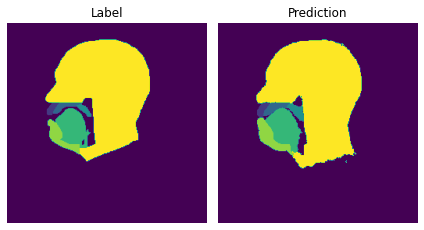

130/130 [==============================] - 74s 573ms/step - loss: 0.0330 - Mean_DICE: 0.8334 - precision_1: 0.9861 - recall_1: 0.9857 - Hausdorff: 21.4285 - val_loss: 0.1244 - val_Mean_DICE: 0.8252 - val_precision_1: 0.9737 - val_recall_1: 0.9726 - val_Hausdorff: 24.5932 - lr: 0.0010
Epoch 17/1000
130/130 [==============================] - ETA: 0s - loss: 0.0333 - Mean_DICE: 0.8485 - precision_1: 0.9857 - recall_1: 0.9854 - Hausdorff: 21.4382

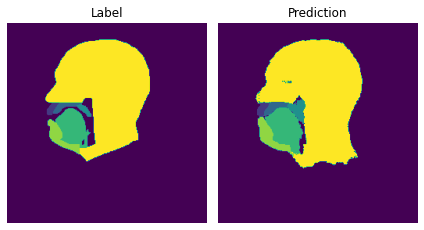

130/130 [==============================] - 75s 575ms/step - loss: 0.0333 - Mean_DICE: 0.8485 - precision_1: 0.9857 - recall_1: 0.9854 - Hausdorff: 21.4382 - val_loss: 0.1408 - val_Mean_DICE: 0.8055 - val_precision_1: 0.9673 - val_recall_1: 0.9662 - val_Hausdorff: 26.5020 - lr: 0.0010
Epoch 18/1000
130/130 [==============================] - ETA: 0s - loss: 0.0315 - Mean_DICE: 0.8687 - precision_1: 0.9864 - recall_1: 0.9861 - Hausdorff: 20.1470

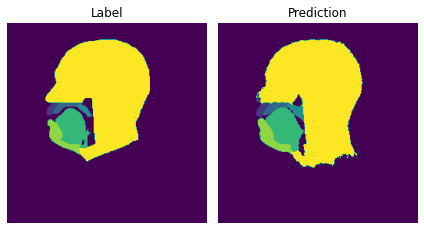

130/130 [==============================] - 73s 559ms/step - loss: 0.0315 - Mean_DICE: 0.8687 - precision_1: 0.9864 - recall_1: 0.9861 - Hausdorff: 20.1470 - val_loss: 0.1507 - val_Mean_DICE: 0.8315 - val_precision_1: 0.9747 - val_recall_1: 0.9736 - val_Hausdorff: 24.7439 - lr: 0.0010
Epoch 19/1000
130/130 [==============================] - ETA: 0s - loss: 0.0239 - Mean_DICE: 0.8759 - precision_1: 0.9878 - recall_1: 0.9876 - Hausdorff: 18.4101

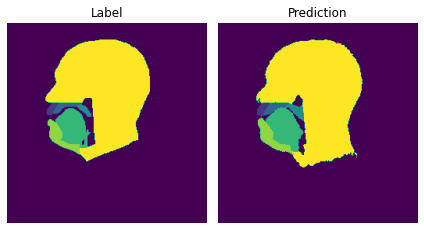

130/130 [==============================] - 73s 565ms/step - loss: 0.0239 - Mean_DICE: 0.8759 - precision_1: 0.9878 - recall_1: 0.9876 - Hausdorff: 18.4101 - val_loss: 0.1484 - val_Mean_DICE: 0.8487 - val_precision_1: 0.9782 - val_recall_1: 0.9775 - val_Hausdorff: 23.0801 - lr: 5.0000e-04
Epoch 20/1000
130/130 [==============================] - ETA: 0s - loss: 0.0203 - Mean_DICE: 0.8935 - precision_1: 0.9885 - recall_1: 0.9883 - Hausdorff: 17.5610

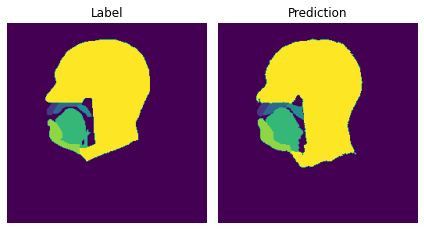

130/130 [==============================] - 75s 574ms/step - loss: 0.0203 - Mean_DICE: 0.8935 - precision_1: 0.9885 - recall_1: 0.9883 - Hausdorff: 17.5610 - val_loss: 0.1713 - val_Mean_DICE: 0.8593 - val_precision_1: 0.9787 - val_recall_1: 0.9781 - val_Hausdorff: 22.7902 - lr: 5.0000e-04
Epoch 21/1000
130/130 [==============================] - ETA: 0s - loss: 0.0191 - Mean_DICE: 0.8960 - precision_1: 0.9890 - recall_1: 0.9888 - Hausdorff: 18.9514

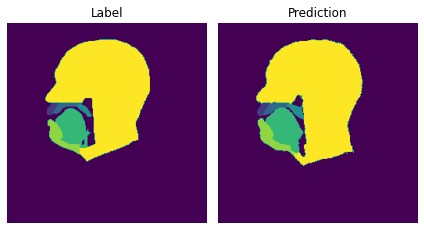

130/130 [==============================] - 73s 563ms/step - loss: 0.0191 - Mean_DICE: 0.8960 - precision_1: 0.9890 - recall_1: 0.9888 - Hausdorff: 18.9514 - val_loss: 0.1905 - val_Mean_DICE: 0.8647 - val_precision_1: 0.9793 - val_recall_1: 0.9788 - val_Hausdorff: 21.4779 - lr: 5.0000e-04
Epoch 22/1000
130/130 [==============================] - ETA: 0s - loss: 0.0188 - Mean_DICE: 0.8845 - precision_1: 0.9890 - recall_1: 0.9888 - Hausdorff: 18.8219

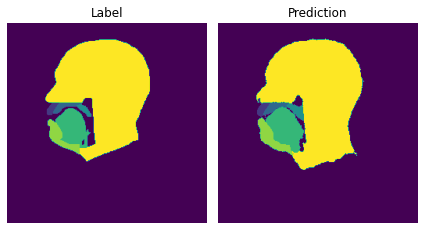

130/130 [==============================] - 75s 576ms/step - loss: 0.0188 - Mean_DICE: 0.8845 - precision_1: 0.9890 - recall_1: 0.9888 - Hausdorff: 18.8219 - val_loss: 0.1825 - val_Mean_DICE: 0.8425 - val_precision_1: 0.9754 - val_recall_1: 0.9748 - val_Hausdorff: 21.8728 - lr: 5.0000e-04
Epoch 23/1000
130/130 [==============================] - ETA: 0s - loss: 0.0180 - Mean_DICE: 0.8964 - precision_1: 0.9893 - recall_1: 0.9891 - Hausdorff: 20.7134

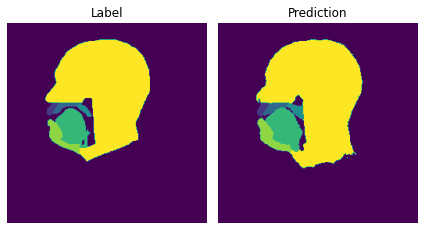

130/130 [==============================] - 73s 562ms/step - loss: 0.0180 - Mean_DICE: 0.8964 - precision_1: 0.9893 - recall_1: 0.9891 - Hausdorff: 20.7134 - val_loss: 0.1810 - val_Mean_DICE: 0.8514 - val_precision_1: 0.9769 - val_recall_1: 0.9764 - val_Hausdorff: 23.8860 - lr: 5.0000e-04
Epoch 24/1000
130/130 [==============================] - ETA: 0s - loss: 0.0168 - Mean_DICE: 0.9061 - precision_1: 0.9896 - recall_1: 0.9894 - Hausdorff: 19.4354

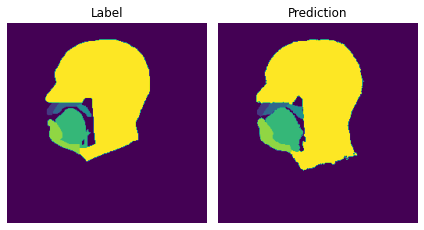

130/130 [==============================] - 75s 577ms/step - loss: 0.0168 - Mean_DICE: 0.9061 - precision_1: 0.9896 - recall_1: 0.9894 - Hausdorff: 19.4354 - val_loss: 0.1979 - val_Mean_DICE: 0.8629 - val_precision_1: 0.9757 - val_recall_1: 0.9752 - val_Hausdorff: 23.2676 - lr: 5.0000e-04
Epoch 25/1000
130/130 [==============================] - ETA: 0s - loss: 0.0169 - Mean_DICE: 0.9034 - precision_1: 0.9897 - recall_1: 0.9896 - Hausdorff: 20.5369

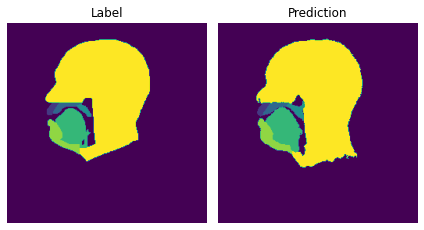

130/130 [==============================] - 73s 563ms/step - loss: 0.0169 - Mean_DICE: 0.9034 - precision_1: 0.9897 - recall_1: 0.9896 - Hausdorff: 20.5369 - val_loss: 0.2293 - val_Mean_DICE: 0.8670 - val_precision_1: 0.9781 - val_recall_1: 0.9775 - val_Hausdorff: 22.8395 - lr: 5.0000e-04
Epoch 26/1000
130/130 [==============================] - ETA: 0s - loss: 0.0169 - Mean_DICE: 0.9067 - precision_1: 0.9897 - recall_1: 0.9896 - Hausdorff: 19.5860

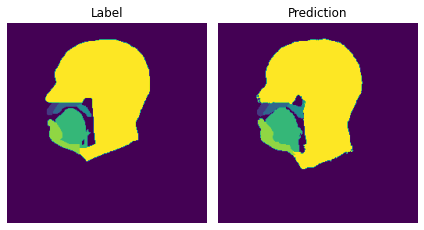

130/130 [==============================] - 74s 573ms/step - loss: 0.0169 - Mean_DICE: 0.9067 - precision_1: 0.9897 - recall_1: 0.9896 - Hausdorff: 19.5860 - val_loss: 0.1993 - val_Mean_DICE: 0.8636 - val_precision_1: 0.9781 - val_recall_1: 0.9776 - val_Hausdorff: 21.1108 - lr: 5.0000e-04
Epoch 27/1000
130/130 [==============================] - ETA: 0s - loss: 0.0154 - Mean_DICE: 0.8954 - precision_1: 0.9900 - recall_1: 0.9899 - Hausdorff: 19.3487

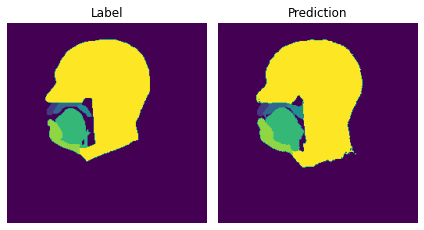

130/130 [==============================] - 75s 577ms/step - loss: 0.0154 - Mean_DICE: 0.8954 - precision_1: 0.9900 - recall_1: 0.9899 - Hausdorff: 19.3487 - val_loss: 0.2181 - val_Mean_DICE: 0.8565 - val_precision_1: 0.9786 - val_recall_1: 0.9781 - val_Hausdorff: 21.3298 - lr: 5.0000e-04
Epoch 28/1000
130/130 [==============================] - ETA: 0s - loss: 0.0143 - Mean_DICE: 0.9015 - precision_1: 0.9903 - recall_1: 0.9902 - Hausdorff: 18.6586

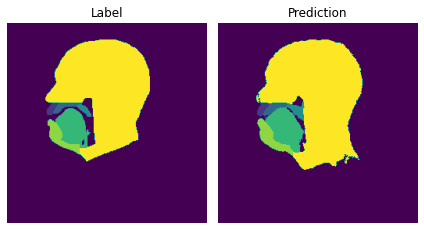

130/130 [==============================] - 73s 562ms/step - loss: 0.0143 - Mean_DICE: 0.9015 - precision_1: 0.9903 - recall_1: 0.9902 - Hausdorff: 18.6586 - val_loss: 0.2143 - val_Mean_DICE: 0.8480 - val_precision_1: 0.9761 - val_recall_1: 0.9756 - val_Hausdorff: 21.5219 - lr: 5.0000e-04
Epoch 29/1000
130/130 [==============================] - ETA: 0s - loss: 0.0141 - Mean_DICE: 0.8958 - precision_1: 0.9903 - recall_1: 0.9901 - Hausdorff: 16.0421

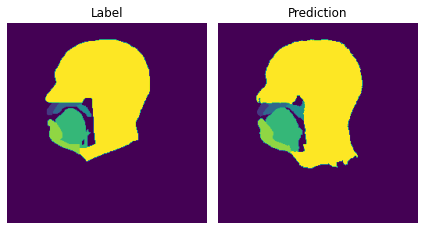

130/130 [==============================] - 75s 576ms/step - loss: 0.0141 - Mean_DICE: 0.8958 - precision_1: 0.9903 - recall_1: 0.9901 - Hausdorff: 16.0421 - val_loss: 0.2447 - val_Mean_DICE: 0.8520 - val_precision_1: 0.9775 - val_recall_1: 0.9771 - val_Hausdorff: 22.6698 - lr: 5.0000e-04
Epoch 30/1000
130/130 [==============================] - ETA: 0s - loss: 0.0136 - Mean_DICE: 0.8938 - precision_1: 0.9906 - recall_1: 0.9905 - Hausdorff: 19.0420

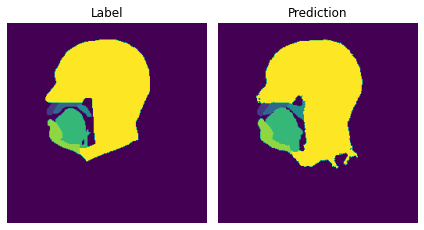

130/130 [==============================] - 73s 560ms/step - loss: 0.0136 - Mean_DICE: 0.8938 - precision_1: 0.9906 - recall_1: 0.9905 - Hausdorff: 19.0420 - val_loss: 0.2140 - val_Mean_DICE: 0.8468 - val_precision_1: 0.9781 - val_recall_1: 0.9776 - val_Hausdorff: 21.7736 - lr: 5.0000e-04
Epoch 31/1000
130/130 [==============================] - ETA: 0s - loss: 0.0121 - Mean_DICE: 0.9000 - precision_1: 0.9911 - recall_1: 0.9910 - Hausdorff: 16.4675

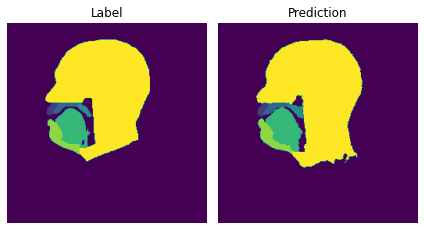

130/130 [==============================] - 73s 565ms/step - loss: 0.0121 - Mean_DICE: 0.9000 - precision_1: 0.9911 - recall_1: 0.9910 - Hausdorff: 16.4675 - val_loss: 0.2658 - val_Mean_DICE: 0.8791 - val_precision_1: 0.9807 - val_recall_1: 0.9804 - val_Hausdorff: 22.1857 - lr: 2.5000e-04
Epoch 32/1000
130/130 [==============================] - ETA: 0s - loss: 0.0101 - Mean_DICE: 0.9181 - precision_1: 0.9918 - recall_1: 0.9917 - Hausdorff: 17.7237

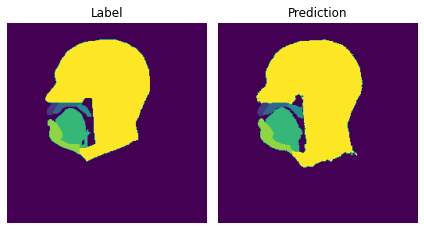

130/130 [==============================] - 73s 563ms/step - loss: 0.0101 - Mean_DICE: 0.9181 - precision_1: 0.9918 - recall_1: 0.9917 - Hausdorff: 17.7237 - val_loss: 0.2835 - val_Mean_DICE: 0.8804 - val_precision_1: 0.9813 - val_recall_1: 0.9810 - val_Hausdorff: 21.4092 - lr: 2.5000e-04
Epoch 33/1000
130/130 [==============================] - ETA: 0s - loss: 0.0094 - Mean_DICE: 0.9345 - precision_1: 0.9921 - recall_1: 0.9920 - Hausdorff: 17.1263

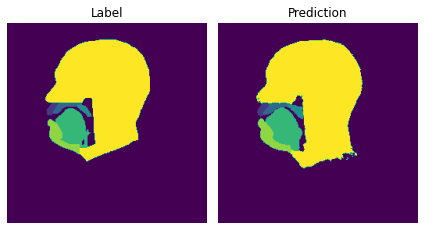

130/130 [==============================] - 76s 587ms/step - loss: 0.0094 - Mean_DICE: 0.9345 - precision_1: 0.9921 - recall_1: 0.9920 - Hausdorff: 17.1263 - val_loss: 0.2978 - val_Mean_DICE: 0.8786 - val_precision_1: 0.9805 - val_recall_1: 0.9802 - val_Hausdorff: 21.7948 - lr: 2.5000e-04
Epoch 34/1000
130/130 [==============================] - ETA: 0s - loss: 0.0093 - Mean_DICE: 0.9184 - precision_1: 0.9922 - recall_1: 0.9921 - Hausdorff: 18.7096

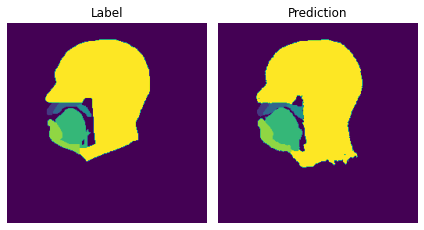

130/130 [==============================] - 73s 565ms/step - loss: 0.0093 - Mean_DICE: 0.9184 - precision_1: 0.9922 - recall_1: 0.9921 - Hausdorff: 18.7096 - val_loss: 0.2894 - val_Mean_DICE: 0.8676 - val_precision_1: 0.9778 - val_recall_1: 0.9775 - val_Hausdorff: 22.0419 - lr: 2.5000e-04
Epoch 35/1000
130/130 [==============================] - ETA: 0s - loss: 0.0090 - Mean_DICE: 0.9170 - precision_1: 0.9924 - recall_1: 0.9923 - Hausdorff: 19.4917

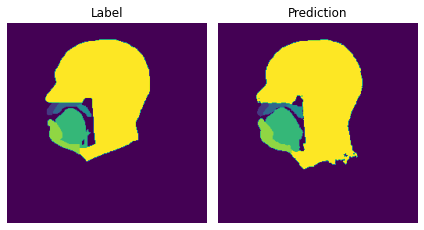

130/130 [==============================] - 76s 583ms/step - loss: 0.0090 - Mean_DICE: 0.9170 - precision_1: 0.9924 - recall_1: 0.9923 - Hausdorff: 19.4917 - val_loss: 0.3204 - val_Mean_DICE: 0.8769 - val_precision_1: 0.9787 - val_recall_1: 0.9784 - val_Hausdorff: 21.2719 - lr: 2.5000e-04
Epoch 36/1000
130/130 [==============================] - ETA: 0s - loss: 0.0088 - Mean_DICE: 0.9494 - precision_1: 0.9925 - recall_1: 0.9925 - Hausdorff: 16.3943

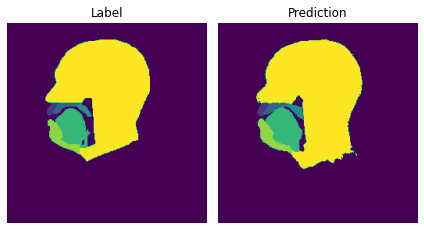

130/130 [==============================] - 77s 592ms/step - loss: 0.0088 - Mean_DICE: 0.9494 - precision_1: 0.9925 - recall_1: 0.9925 - Hausdorff: 16.3943 - val_loss: 0.3317 - val_Mean_DICE: 0.8793 - val_precision_1: 0.9799 - val_recall_1: 0.9797 - val_Hausdorff: 21.1466 - lr: 2.5000e-04
Epoch 37/1000
130/130 [==============================] - ETA: 0s - loss: 0.0084 - Mean_DICE: 0.9131 - precision_1: 0.9927 - recall_1: 0.9926 - Hausdorff: 15.6234

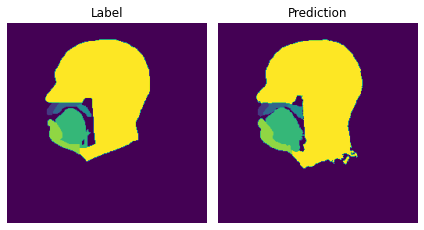

130/130 [==============================] - 75s 575ms/step - loss: 0.0084 - Mean_DICE: 0.9131 - precision_1: 0.9927 - recall_1: 0.9926 - Hausdorff: 15.6234 - val_loss: 0.3215 - val_Mean_DICE: 0.8782 - val_precision_1: 0.9795 - val_recall_1: 0.9792 - val_Hausdorff: 21.6025 - lr: 2.5000e-04
Epoch 38/1000
130/130 [==============================] - ETA: 0s - loss: 0.0079 - Mean_DICE: 0.9383 - precision_1: 0.9930 - recall_1: 0.9929 - Hausdorff: 18.1180

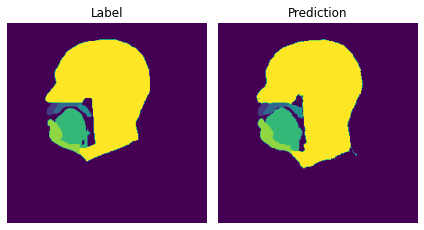

130/130 [==============================] - 75s 574ms/step - loss: 0.0079 - Mean_DICE: 0.9383 - precision_1: 0.9930 - recall_1: 0.9929 - Hausdorff: 18.1180 - val_loss: 0.3626 - val_Mean_DICE: 0.8857 - val_precision_1: 0.9813 - val_recall_1: 0.9811 - val_Hausdorff: 20.4994 - lr: 1.2500e-04
Epoch 39/1000
130/130 [==============================] - ETA: 0s - loss: 0.0073 - Mean_DICE: 0.9453 - precision_1: 0.9932 - recall_1: 0.9932 - Hausdorff: 16.4465

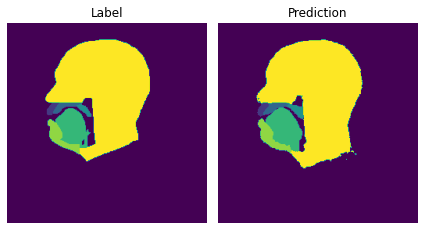

130/130 [==============================] - 73s 563ms/step - loss: 0.0073 - Mean_DICE: 0.9453 - precision_1: 0.9932 - recall_1: 0.9932 - Hausdorff: 16.4465 - val_loss: 0.3472 - val_Mean_DICE: 0.8771 - val_precision_1: 0.9809 - val_recall_1: 0.9807 - val_Hausdorff: 21.4067 - lr: 1.2500e-04
Epoch 40/1000
130/130 [==============================] - ETA: 0s - loss: 0.0071 - Mean_DICE: 0.9294 - precision_1: 0.9934 - recall_1: 0.9933 - Hausdorff: 17.3364

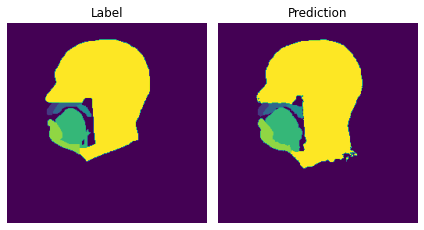

130/130 [==============================] - 73s 563ms/step - loss: 0.0071 - Mean_DICE: 0.9294 - precision_1: 0.9934 - recall_1: 0.9933 - Hausdorff: 17.3364 - val_loss: 0.3798 - val_Mean_DICE: 0.8807 - val_precision_1: 0.9805 - val_recall_1: 0.9803 - val_Hausdorff: 21.0708 - lr: 1.2500e-04
Epoch 41/1000
130/130 [==============================] - ETA: 0s - loss: 0.0069 - Mean_DICE: 0.9266 - precision_1: 0.9935 - recall_1: 0.9935 - Hausdorff: 16.6482

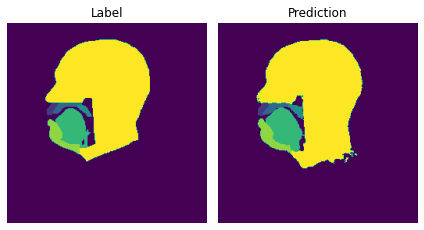

130/130 [==============================] - 76s 584ms/step - loss: 0.0069 - Mean_DICE: 0.9266 - precision_1: 0.9935 - recall_1: 0.9935 - Hausdorff: 16.6482 - val_loss: 0.3800 - val_Mean_DICE: 0.8800 - val_precision_1: 0.9803 - val_recall_1: 0.9801 - val_Hausdorff: 21.4783 - lr: 1.2500e-04
Epoch 42/1000
130/130 [==============================] - ETA: 0s - loss: 0.0070 - Mean_DICE: 0.9289 - precision_1: 0.9935 - recall_1: 0.9935 - Hausdorff: 16.1780

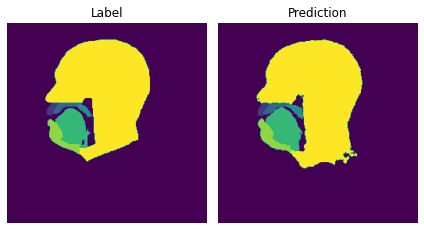

130/130 [==============================] - 75s 573ms/step - loss: 0.0070 - Mean_DICE: 0.9289 - precision_1: 0.9935 - recall_1: 0.9935 - Hausdorff: 16.1780 - val_loss: 0.3777 - val_Mean_DICE: 0.8821 - val_precision_1: 0.9807 - val_recall_1: 0.9804 - val_Hausdorff: 21.1372 - lr: 1.2500e-04
Epoch 43/1000
130/130 [==============================] - ETA: 0s - loss: 0.0067 - Mean_DICE: 0.9355 - precision_1: 0.9937 - recall_1: 0.9936 - Hausdorff: 15.6556

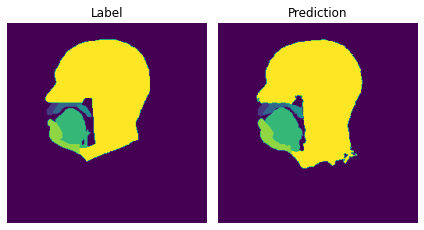

130/130 [==============================] - 75s 579ms/step - loss: 0.0067 - Mean_DICE: 0.9355 - precision_1: 0.9937 - recall_1: 0.9936 - Hausdorff: 15.6556 - val_loss: 0.4043 - val_Mean_DICE: 0.8802 - val_precision_1: 0.9801 - val_recall_1: 0.9799 - val_Hausdorff: 21.2133 - lr: 1.2500e-04
Epoch 44/1000
130/130 [==============================] - ETA: 0s - loss: 0.0063 - Mean_DICE: 0.9470 - precision_1: 0.9939 - recall_1: 0.9939 - Hausdorff: 14.9500

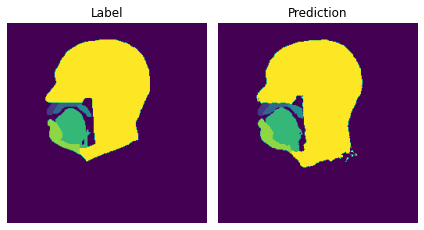

130/130 [==============================] - 73s 564ms/step - loss: 0.0063 - Mean_DICE: 0.9470 - precision_1: 0.9939 - recall_1: 0.9939 - Hausdorff: 14.9500 - val_loss: 0.4153 - val_Mean_DICE: 0.8863 - val_precision_1: 0.9810 - val_recall_1: 0.9808 - val_Hausdorff: 20.7311 - lr: 6.2500e-05
Epoch 45/1000
130/130 [==============================] - ETA: 0s - loss: 0.0061 - Mean_DICE: 0.9565 - precision_1: 0.9940 - recall_1: 0.9940 - Hausdorff: 16.7226

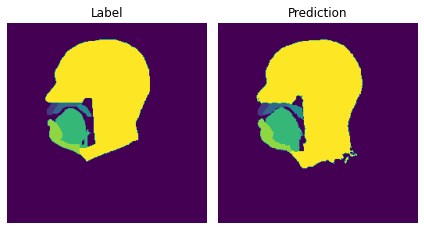

130/130 [==============================] - 73s 562ms/step - loss: 0.0061 - Mean_DICE: 0.9565 - precision_1: 0.9940 - recall_1: 0.9940 - Hausdorff: 16.7226 - val_loss: 0.4186 - val_Mean_DICE: 0.8844 - val_precision_1: 0.9806 - val_recall_1: 0.9804 - val_Hausdorff: 20.7394 - lr: 6.2500e-05
Epoch 46/1000
130/130 [==============================] - ETA: 0s - loss: 0.0059 - Mean_DICE: 0.9410 - precision_1: 0.9941 - recall_1: 0.9941 - Hausdorff: 18.7919

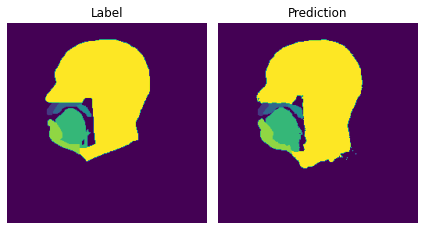

130/130 [==============================] - 74s 567ms/step - loss: 0.0059 - Mean_DICE: 0.9410 - precision_1: 0.9941 - recall_1: 0.9941 - Hausdorff: 18.7919 - val_loss: 0.4364 - val_Mean_DICE: 0.8853 - val_precision_1: 0.9810 - val_recall_1: 0.9808 - val_Hausdorff: 20.7408 - lr: 6.2500e-05
Epoch 47/1000
130/130 [==============================] - ETA: 0s - loss: 0.0059 - Mean_DICE: 0.9431 - precision_1: 0.9942 - recall_1: 0.9941 - Hausdorff: 13.9944

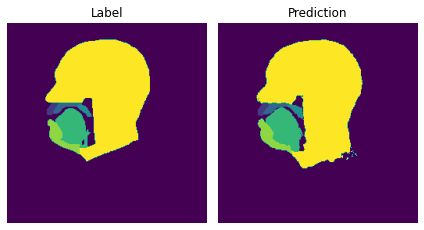

130/130 [==============================] - 73s 562ms/step - loss: 0.0059 - Mean_DICE: 0.9431 - precision_1: 0.9942 - recall_1: 0.9941 - Hausdorff: 13.9944 - val_loss: 0.4311 - val_Mean_DICE: 0.8855 - val_precision_1: 0.9811 - val_recall_1: 0.9809 - val_Hausdorff: 20.9326 - lr: 6.2500e-05
Epoch 48/1000
130/130 [==============================] - ETA: 0s - loss: 0.0059 - Mean_DICE: 0.9503 - precision_1: 0.9942 - recall_1: 0.9941 - Hausdorff: 16.7449

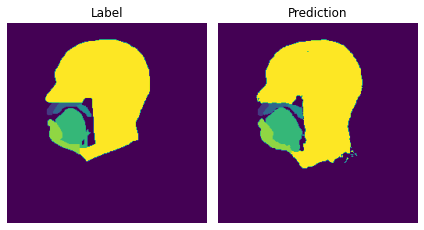

130/130 [==============================] - 74s 566ms/step - loss: 0.0059 - Mean_DICE: 0.9503 - precision_1: 0.9942 - recall_1: 0.9941 - Hausdorff: 16.7449 - val_loss: 0.4530 - val_Mean_DICE: 0.8825 - val_precision_1: 0.9803 - val_recall_1: 0.9801 - val_Hausdorff: 21.2337 - lr: 6.2500e-05
Epoch 49/1000
130/130 [==============================] - ETA: 0s - loss: 0.0057 - Mean_DICE: 0.9335 - precision_1: 0.9943 - recall_1: 0.9943 - Hausdorff: 14.7867

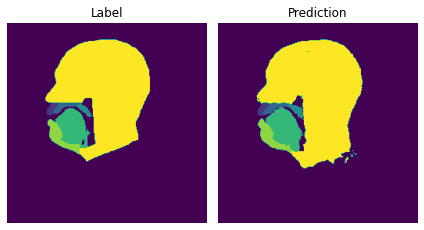

130/130 [==============================] - 75s 574ms/step - loss: 0.0057 - Mean_DICE: 0.9335 - precision_1: 0.9943 - recall_1: 0.9943 - Hausdorff: 14.7867 - val_loss: 0.4454 - val_Mean_DICE: 0.8848 - val_precision_1: 0.9808 - val_recall_1: 0.9806 - val_Hausdorff: 20.9217 - lr: 6.2500e-05
Epoch 50/1000
130/130 [==============================] - ETA: 0s - loss: 0.0056 - Mean_DICE: 0.9384 - precision_1: 0.9944 - recall_1: 0.9943 - Hausdorff: 16.0074

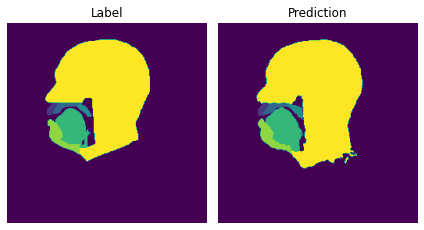

130/130 [==============================] - 74s 566ms/step - loss: 0.0056 - Mean_DICE: 0.9384 - precision_1: 0.9944 - recall_1: 0.9943 - Hausdorff: 16.0074 - val_loss: 0.4511 - val_Mean_DICE: 0.8839 - val_precision_1: 0.9802 - val_recall_1: 0.9800 - val_Hausdorff: 21.4294 - lr: 3.1250e-05
Epoch 51/1000
130/130 [==============================] - ETA: 0s - loss: 0.0054 - Mean_DICE: 0.9566 - precision_1: 0.9945 - recall_1: 0.9944 - Hausdorff: 15.1969

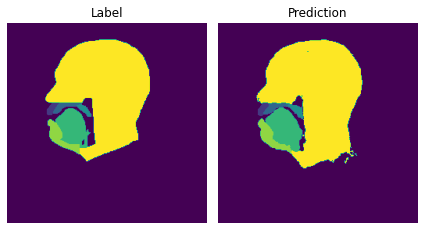

130/130 [==============================] - 73s 562ms/step - loss: 0.0054 - Mean_DICE: 0.9566 - precision_1: 0.9945 - recall_1: 0.9944 - Hausdorff: 15.1969 - val_loss: 0.4463 - val_Mean_DICE: 0.8829 - val_precision_1: 0.9804 - val_recall_1: 0.9803 - val_Hausdorff: 21.3747 - lr: 3.1250e-05
Epoch 52/1000
130/130 [==============================] - ETA: 0s - loss: 0.0054 - Mean_DICE: 0.9493 - precision_1: 0.9945 - recall_1: 0.9945 - Hausdorff: 16.2864

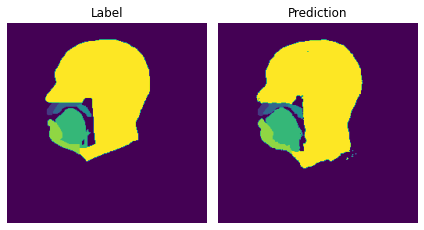

130/130 [==============================] - 73s 564ms/step - loss: 0.0054 - Mean_DICE: 0.9493 - precision_1: 0.9945 - recall_1: 0.9945 - Hausdorff: 16.2864 - val_loss: 0.4519 - val_Mean_DICE: 0.8851 - val_precision_1: 0.9809 - val_recall_1: 0.9807 - val_Hausdorff: 20.9506 - lr: 3.1250e-05
Epoch 53/1000
130/130 [==============================] - ETA: 0s - loss: 0.0053 - Mean_DICE: 0.9508 - precision_1: 0.9946 - recall_1: 0.9945 - Hausdorff: 14.4439

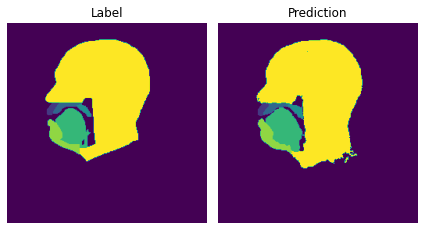

130/130 [==============================] - 75s 574ms/step - loss: 0.0053 - Mean_DICE: 0.9508 - precision_1: 0.9946 - recall_1: 0.9945 - Hausdorff: 14.4439 - val_loss: 0.4481 - val_Mean_DICE: 0.8816 - val_precision_1: 0.9802 - val_recall_1: 0.9800 - val_Hausdorff: 21.0543 - lr: 3.1250e-05
Epoch 54/1000
130/130 [==============================] - ETA: 0s - loss: 0.0053 - Mean_DICE: 0.9377 - precision_1: 0.9946 - recall_1: 0.9945 - Hausdorff: 16.2865

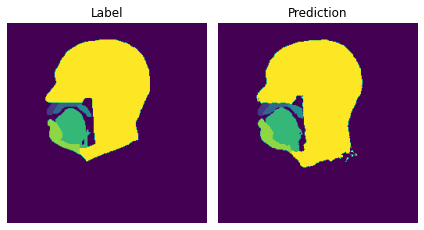

130/130 [==============================] - 75s 581ms/step - loss: 0.0053 - Mean_DICE: 0.9377 - precision_1: 0.9946 - recall_1: 0.9945 - Hausdorff: 16.2865 - val_loss: 0.4625 - val_Mean_DICE: 0.8851 - val_precision_1: 0.9805 - val_recall_1: 0.9804 - val_Hausdorff: 21.3697 - lr: 3.1250e-05


In [ ]:
#model.fit --> actual training of the model using back-propagation for updating weights

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = 1000,
    validation_data = (x_val, y_val),
    callbacks = callbacks
).history

In [ ]:
model.save(best_model_path)

In [ ]:
with open(training_path + '/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)


## Evaluation

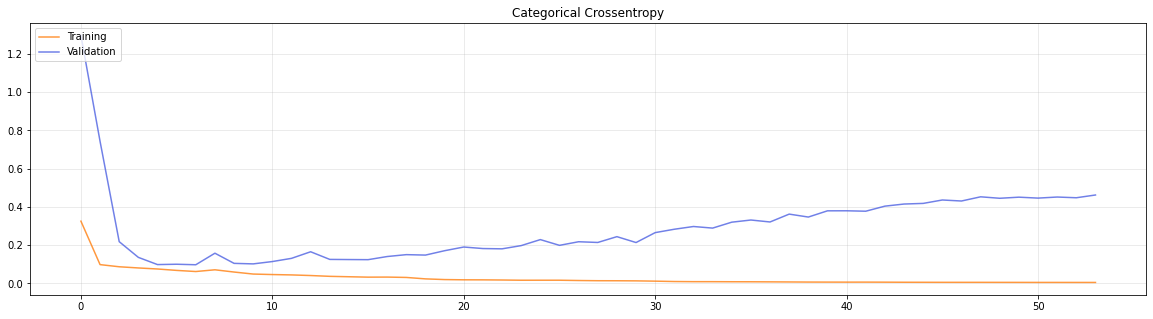

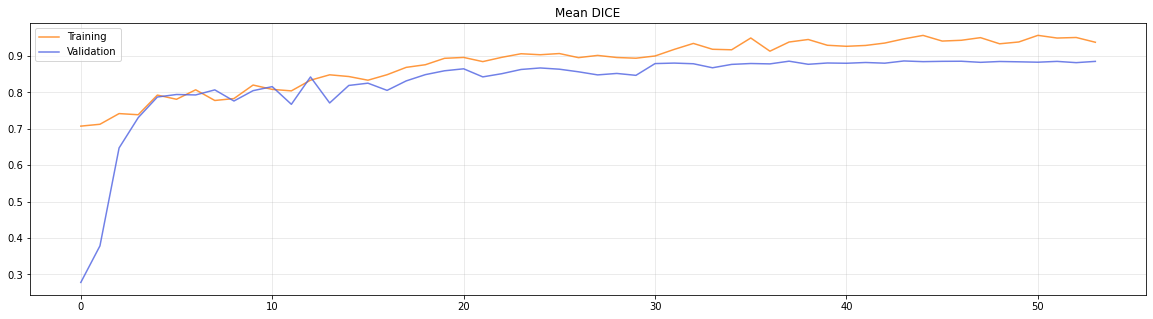

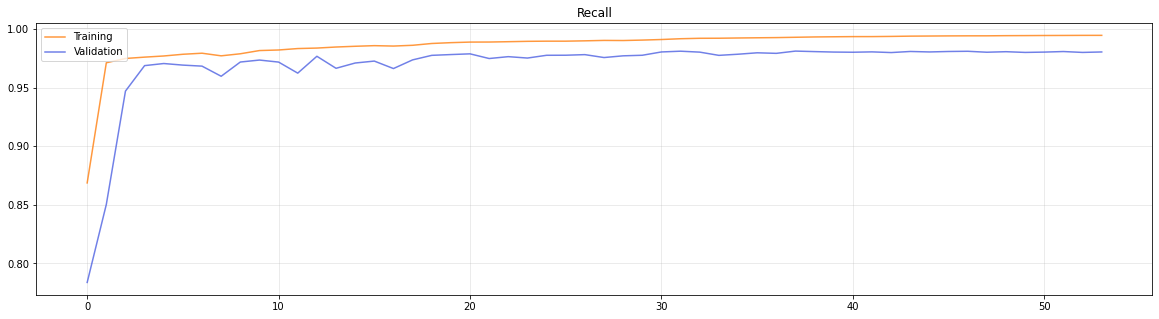

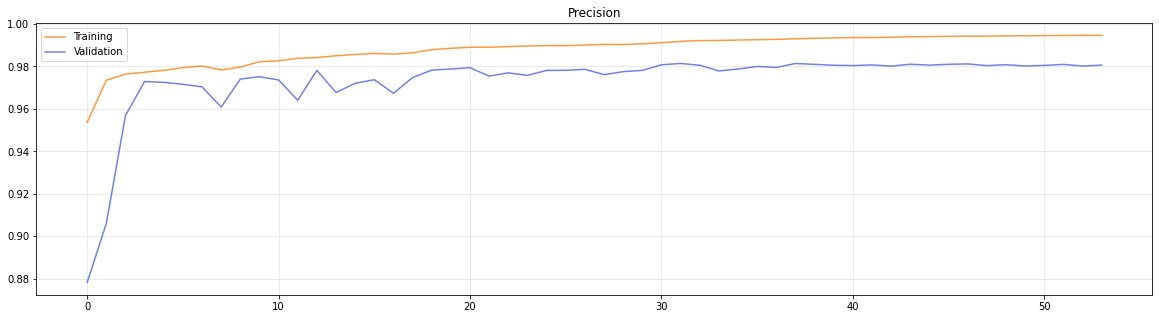

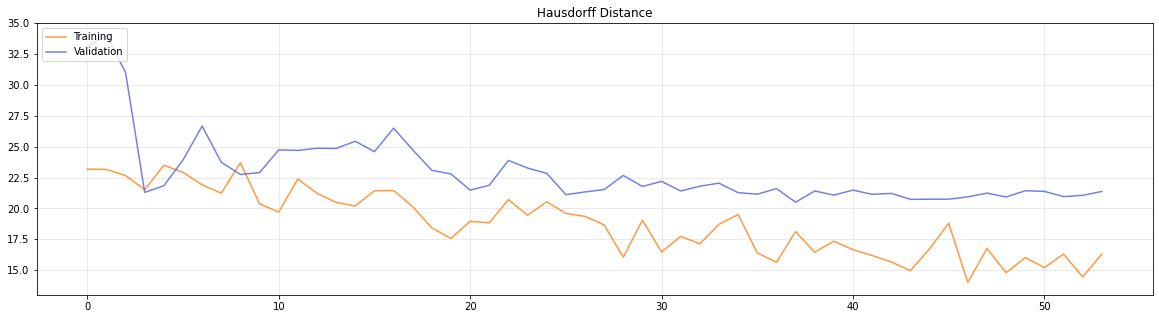

In [ ]:
# Plot the training

# loss
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

# DICE
plt.figure(figsize=(20,5))
plt.plot(history['Mean_DICE'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_Mean_DICE'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Mean DICE')
plt.grid(alpha=.3)

# Recall
plt.figure(figsize=(20,5))
plt.plot(history['recall_1'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_recall_1'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Recall')
plt.grid(alpha=.3)

# Precision
plt.figure(figsize=(20,5))
plt.plot(history['precision_1'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_precision_1'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Precision')
plt.grid(alpha=.3)

# Hausdorff
plt.figure(figsize=(20,5))
plt.plot(history['Hausdorff'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_Hausdorff'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Hausdorff Distance')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.evaluate(x = x_val, y = y_val, verbose = 2)

5/5 - 12s - loss: 0.4153 - Mean_DICE: 0.8842 - precision_1: 0.9810 - recall_1: 0.9808 - Hausdorff: 25.2683 - 12s/epoch - 2s/step


[0.41525551676750183,
 0.8841580748558044,
 0.9809892773628235,
 0.9807838797569275,
 25.268260955810547]

In [ ]:
val_predictions = model.predict(x_val)

5/5 [==============================] - 2s 394ms/step


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 1e-9
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_for_each_class(y_true, y_pred, numLabels):
    dice=[]
    for index in range(numLabels):
        dice.append(dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index]))
    return dice 

In [ ]:
class_dices = dice_for_each_class(y_val,val_predictions, NUM_CLASSES)

In [ ]:
print('Mean DICE: validation set\n')
for i in range(NUM_CLASSES):
  print('{}: {}'.format(class_labels[i], round(class_dices[i],2)))

Mean DICE: validation set

Background: 0.99
Upper lip: 0.82
Hard palate: 0.83
Soft palate: 0.79
Tongue: 0.93
Lower lip: 0.9
Head: 0.96


## Test set

In [ ]:
x_test = preprocessing(x_test)

In [ ]:
#Network evaluation on the test set
test_scores = model.evaluate(x = x_test, y = y_test, verbose = 2)

5/5 - 3s - loss: 0.5319 - Mean_DICE: 0.9045 - precision_1: 0.9849 - recall_1: 0.9847 - Hausdorff: 21.8504 - 3s/epoch - 619ms/step


In [ ]:
predictions = model.predict(x_test)
print('prediction shape: {}'.format(predictions.shape))

5/5 [==============================] - 2s 454ms/step
prediction shape: (150, 256, 256, 7)


In [ ]:
class_dices = dice_for_each_class(y_test, predictions, NUM_CLASSES)

In [ ]:
print('Mean DICE: test set\n')
for i in range(NUM_CLASSES):
  print('{}: {}'.format(class_labels[i], round(class_dices[i],2)))

Mean DICE: test set

Background: 0.99
Upper lip: 0.9
Hard palate: 0.82
Soft palate: 0.8
Tongue: 0.93
Lower lip: 0.9
Head: 0.97


## Predictions Plotting

Img n°:  0


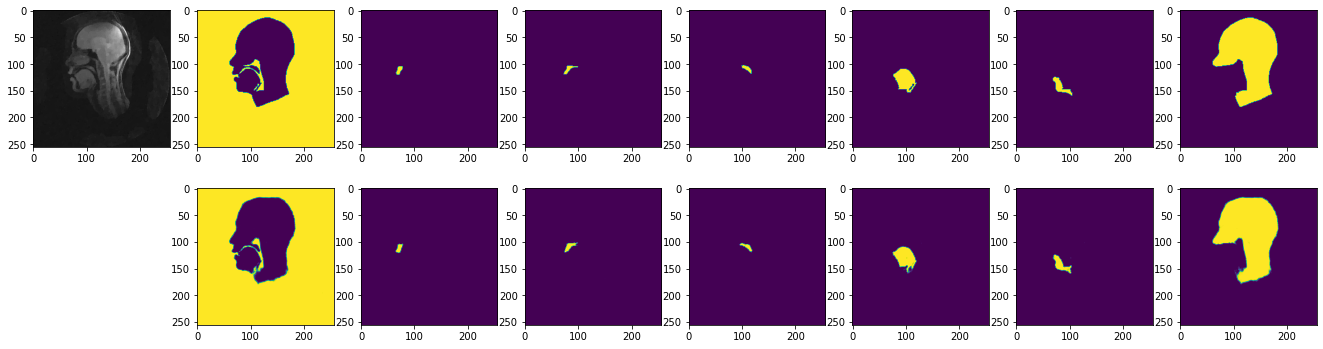

Img n°:  1


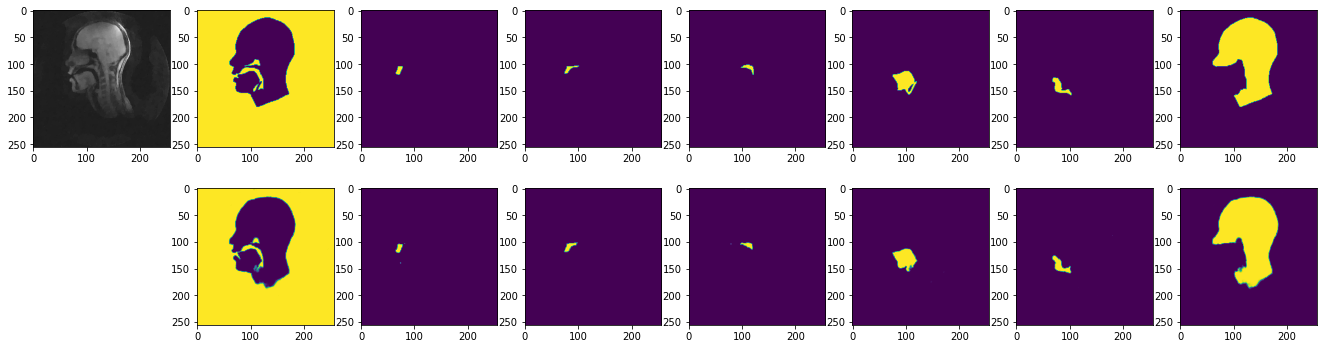

Img n°:  2


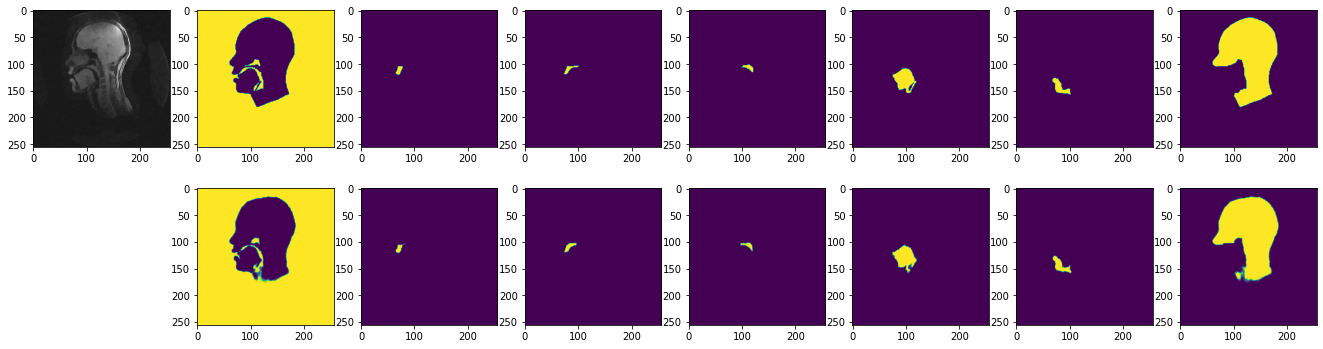

Img n°:  3


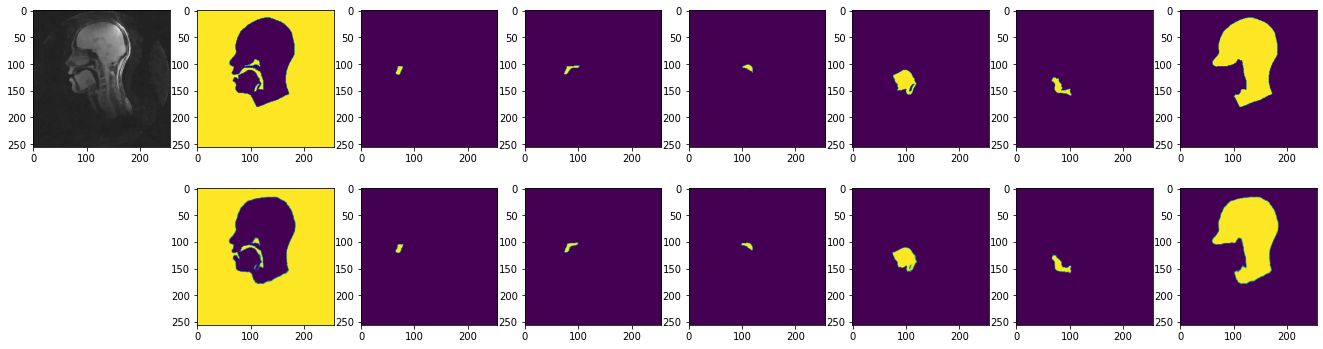

Img n°:  4


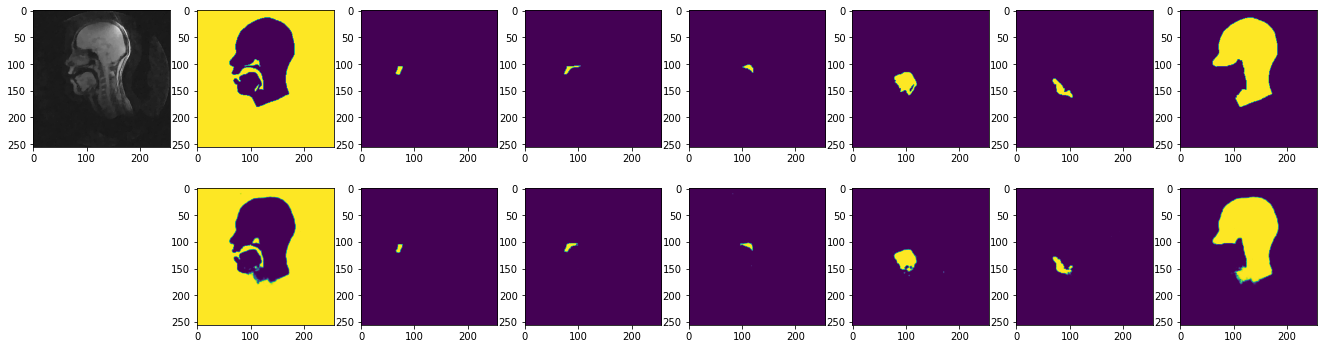

In [ ]:
n = 0
for volume, label in zip(x_test, y_test):  
    
    print("Img n°: ", n)

    fig = plt.figure(figsize = [23, 6])     #generate the withe figure (background)
    plt.subplot(2, (NUM_CLASSES + 1), 1)    #define the grid size (r, c, index) (index must be >= 1)
    plt.imshow(volume[:,:,0], cmap="gray")  #dsMRI image plotting

    for i in range(NUM_CLASSES): #iteration over classes for each image
        
        plt.subplot(2, (NUM_CLASSES + 1), i+2)  #index moving to identify the correct grid coordinate 
        plt.imshow(label[:,:,i])                #Ground Truth plotting
        plt.subplot(2, (NUM_CLASSES + 1), i+10) #index moving to identify the correct grid coordinate
        plt.imshow(predictions[n,:,:,i])        # <--------- Here the predictions plotting  
    
    n = n + 1
    plt.show(fig) #subplot figure plotting
    if n == 5:
      break
n = 0

## Garbage collector


In [ ]:
del x_train, x_test, x_val, y_train, y_test, y_val
import gc
gc.collect()

91243